In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Condition Labels (Target Variables)**
These columns come from the profile.txt file and tell you the condition of the hydraulic system components for each 60-second cycle.


1. Cooler_Cond	: How well the cooler is working.	A percentage (100% is full efficiency, 3% is close to total failure).
2. Valve_Cond	How :fast the valve reacts.	A percentage (100% is optimal/fast, 73% is a near-failure lag).
3. Pump_Leak	How much oil is leaking inside the pump.	A number (0 is no leakage, 2 is severe leakage).
4. Accumulator_Press	The pressure inside the accumulator.	A pressure value in bar (130 bar is optimal, 90 bar is close to total failure).
5. Stable_Flag	Was the system running steadily?	0 means the machine was stable; 1 means the machine was still warming up or settling. (You might want to ignore cycles with a '1' in more advanced analysis).

In [16]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data_dir = r'C:\Users\Yashika\smart_maintenance_and_failure_Detection\dataset'  # change path if needed
data_dir = '/content/drive/MyDrive/dataset' # Using Google Drive path
def load_hydraulic_data(data_dir):
    all_files = glob.glob(os.path.join(data_dir, "*.txt"))
    data_dict = {}
    exclude_files = ["description.txt", "documentation.txt"] # Files to exclude
    for file in all_files:
        name = os.path.basename(file)
        if name not in exclude_files: # Check if the file should be excluded
            name = name.replace('.txt', '')
            try:
                df = pd.read_csv(file, sep='\t', header=None)
                data_dict[name] = df
            except Exception:
                df = pd.read_csv(file, sep='\s+', header=None)
                data_dict[name] = df
    return data_dict

sensor_data = load_hydraulic_data(data_dir)

# Assuming profile.txt is not one of the excluded files and is needed
try:
    profile_df = pd.read_csv(os.path.join(data_dir, "profile.txt"), sep='\t', header=None)
    profile_df.columns = ["Cooler_Cond", "Valve_Cond", "Pump_Leak", "Accumulator_Press", "Stable_Flag"]
    print("Profile shape:", profile_df.shape)
except FileNotFoundError:
    print("profile.txt not found in the dataset folder.")


print("Loaded sensors:", list(sensor_data.keys()))

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2849520373.py:22: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, sep='\s+', header=None)


Profile shape: (2205, 5)
Loaded sensors: ['CE', 'CP', 'FS2', 'profile', 'EPS1', 'FS1', 'PS1', 'PS2', 'PS4', 'PS5', 'PS3', 'SE', 'TS1', 'TS2', 'VS1', 'TS3', 'PS6', 'TS4']


Step 3 — Data Preprocessing

We’ll handle:

    Missing values

    Outlier removal (IQR method)

    Normalization

    Feature aggregation per cycle




In [17]:
def preprocess_sensor(df):
    # Fill missing values
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Remove outliers (IQR)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Standardize (per column)
    df = (df - df.mean()) / df.std()
    return df

processed_sensors = {}
for name, df in sensor_data.items():
    processed_sensors[name] = preprocess_sensor(df)


/tmp/ipython-input-1610302149.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-1610302149.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-1610302149.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-1610302149.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-1610302149.py:3: FutureWarning: DataFrame.fillna with 'method' is dep

In [18]:
for name, df in sensor_data.items():
    print(f"{name}: shape={df.shape}, mean={df.mean().mean():.2f}, std={df.std().mean():.2f}")


CE: shape=(2205, 60), mean=31.30, std=11.58
CP: shape=(2205, 60), mean=1.81, std=0.28
FS2: shape=(2205, 600), mean=9.65, std=0.45
profile: shape=(2205, 5), mean=48.03, std=14.16
EPS1: shape=(2205, 6000), mean=2495.51, std=97.84
FS1: shape=(2205, 600), mean=6.20, std=1.21
PS1: shape=(2205, 6000), mean=160.49, std=6.02
PS2: shape=(2205, 6000), mean=109.38, std=6.41
PS4: shape=(2205, 6000), mean=2.60, std=4.30
PS5: shape=(2205, 6000), mean=9.16, std=0.58
PS3: shape=(2205, 6000), mean=1.75, std=0.32
SE: shape=(2205, 60), mean=55.29, std=10.50
TS1: shape=(2205, 60), mean=45.42, std=7.99
TS2: shape=(2205, 60), mean=50.37, std=7.40
VS1: shape=(2205, 60), mean=0.61, std=0.07
TS3: shape=(2205, 60), mean=47.66, std=7.45
PS6: shape=(2205, 6000), mean=9.08, std=0.55
TS4: shape=(2205, 60), mean=40.74, std=8.11


 All sensors show stable readings with relatively low standard deviations, indicating controlled experimental conditions. Temperature sensors show the system operates at moderate temperatures (40-50°C).


Step 4 — Feature Extraction

We can summarize each cycle using simple statistics (mean, std, min, max).
Each row = one cycle (like one observation).

In [19]:
def extract_features(df):
    return pd.DataFrame({
        'mean': df.mean(axis=1),
        'std': df.std(axis=1),
        'max': df.max(axis=1),
        'min': df.min(axis=1),
        'range': df.max(axis=1) - df.min(axis=1),
        'kurtosis': df.kurtosis(axis=1),
        'skew': df.skew(axis=1)
    })

features_df = pd.DataFrame()
for name, df in sensor_data.items():
    feat = extract_features(df)
    feat.columns = [f"{name}_{c}" for c in feat.columns]
    features_df = pd.concat([features_df, feat], axis=1)

full_df = pd.concat([features_df, profile_df], axis=1)
full_df.head()


,CE_mean,CE_std,CE_max,CE_min,CE_range,CE_kurtosis,CE_skew,CP_mean,CP_std,CP_max,...,TS4_max,TS4_min,TS4_range,TS4_kurtosis,TS4_skew,Cooler_Cond,Valve_Cond,Pump_Leak,Accumulator_Press,Stable_Flag
0,39.601350,6.370535,47.438,28.866,18.572,-1.438429,-0.273911,1.862750,0.279385,2.188,...,33.594,30.363,3.231,-1.407325,0.254104,3,100,0,130,1
1,25.786433,1.686129,29.208,23.320,5.888,-1.087683,0.411371,1.255550,0.074605,1.414,...,35.148,33.648,1.500,-1.053366,-0.313176,3,100,0,130,1
2,22.218233,0.638345,23.554,21.220,2.334,-1.094452,0.312096,1.113217,0.023263,1.159,...,36.141,35.098,1.043,-1.045293,-0.097014,3,100,0,130,1
3,20.459817,0.455755,21.565,19.673,1.892,-0.166741,0.188582,1.062150,0.024621,1.107,...,36.988,36.105,0.883,-1.167018,-0.195165,3,100,0,130,1
4,19.787017,0.290156,20.460,19.133,1.327,0.026588,-0.026240,1.070467,0.021477,1.106,...,37.781,36.992,0.789,-1.159541,-0.186079,3,100,0,130,1


Condensed 43,680 time-series data points per cycle into 7 statistical features per sensor, making the data manageable for machine learning (from ~44k to ~126 features per cycle).

Step 5 — Combine with Target Labels

In [8]:
combined_df = pd.concat([feature_data, profile_df], axis=1)
combined_df = combined_df.dropna().reset_index(drop=True)
combined_df.head()


,CE_mean,CE_std,CE_min,CE_max,CP_mean,CP_std,CP_min,CP_max,FS2_mean,FS2_std,...,PS6_max,TS4_mean,TS4_std,TS4_min,TS4_max,Cooler_Cond,Valve_Cond,Pump_Leak,Accumulator_Press,Stable_Flag
0,-0.430871,0.013964,-0.466045,-0.397575,-0.238589,0.046189,-0.349254,-0.134941,-0.244118,0.031636,...,-0.315099,0.339460,0.004673,0.327192,0.347628,20,100,0,90,1
1,-0.423136,0.011621,-0.447069,-0.401138,-0.219595,0.045439,-0.317985,-0.140856,-0.234101,0.031387,...,-0.303435,0.320270,0.001854,0.316942,0.323950,20,100,0,90,1
2,-0.423021,0.009792,-0.441706,-0.398569,-0.287643,0.033713,-0.367034,-0.211088,-0.184921,0.031482,...,-0.275508,0.288858,0.001816,0.284653,0.292772,20,100,0,90,1
3,-0.424698,0.013821,-0.450465,-0.392215,-0.320254,0.043898,-0.401932,-0.212622,-0.105796,0.034563,...,-0.249643,0.235732,0.003108,0.228921,0.240417,20,100,0,90,1
4,-0.433069,0.010846,-0.460583,-0.408288,-0.357306,0.040520,-0.476605,-0.288658,-0.109288,0.035998,...,-0.253110,0.228519,0.001818,0.224513,0.232224,20,100,0,90,1


# **Pressure Distribution Analysis**

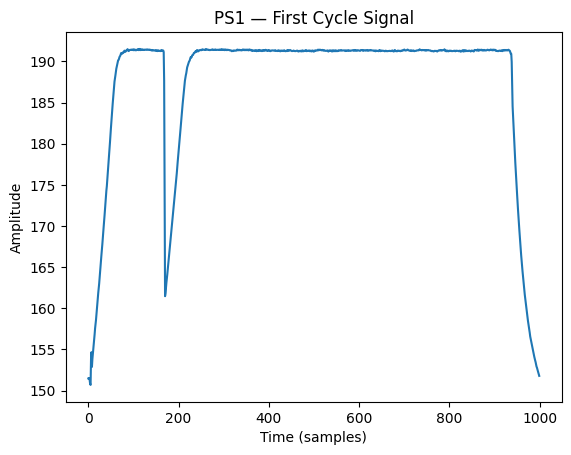

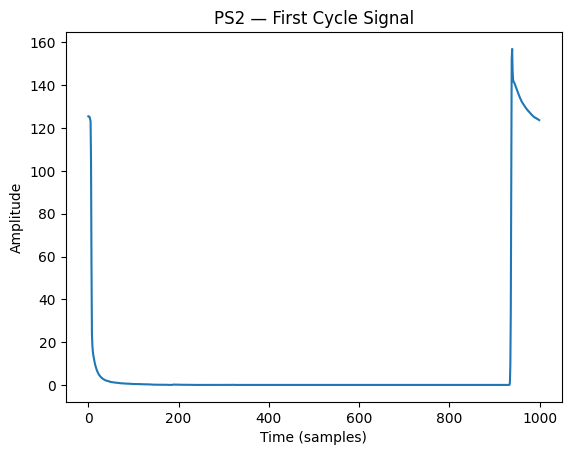

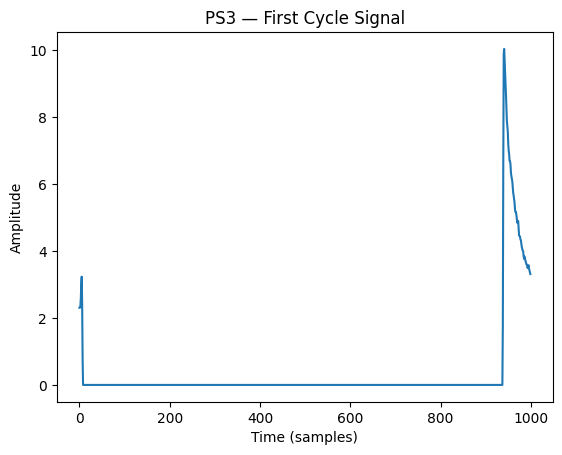

In [32]:
for name in ['PS1', 'PS2', 'PS3']:
    plt.plot(sensor_data[name].iloc[0, :1000])
    plt.title(f'{name} — First Cycle Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


Visualized the first cycle's pressure patterns. Helps identify signal characteristics like amplitude, noise, and cycling behavior.


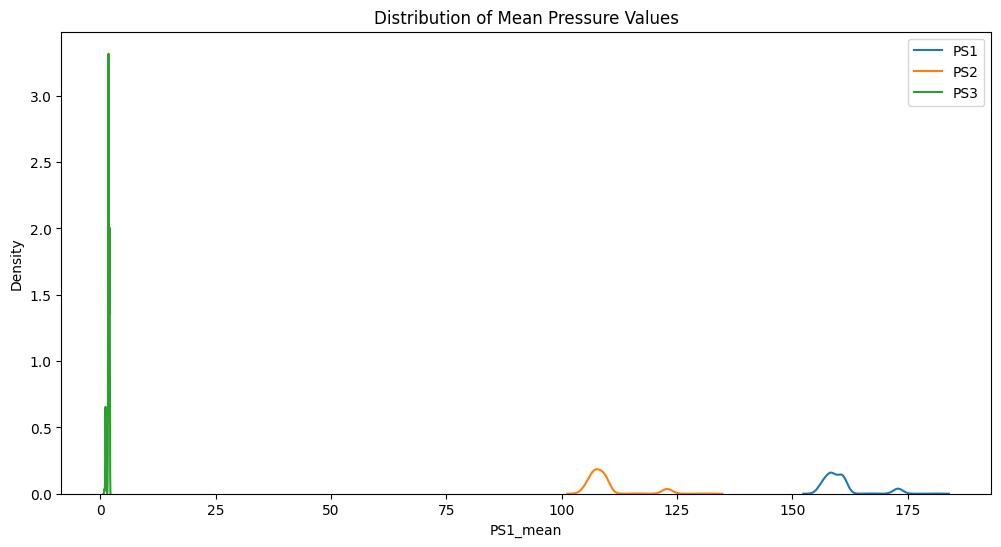

In [22]:
plt.figure(figsize=(12,6))
sns.kdeplot(features_df['PS1_mean'], label='PS1')
sns.kdeplot(features_df['PS2_mean'], label='PS2')
sns.kdeplot(features_df['PS3_mean'], label='PS3')
plt.title('Distribution of Mean Pressure Values')
plt.legend()
plt.show()


- **PS1** shows highest mean pressure (~160 bar)
- **PS2** shows moderate pressure (~110 bar)  
- **PS3** shows lowest pressure (~2 bar)
- Each sensor has distinct pressure ranges, indicating they measure different parts of the hydraulic circuit.


# **Overall Correlation Heatmap**

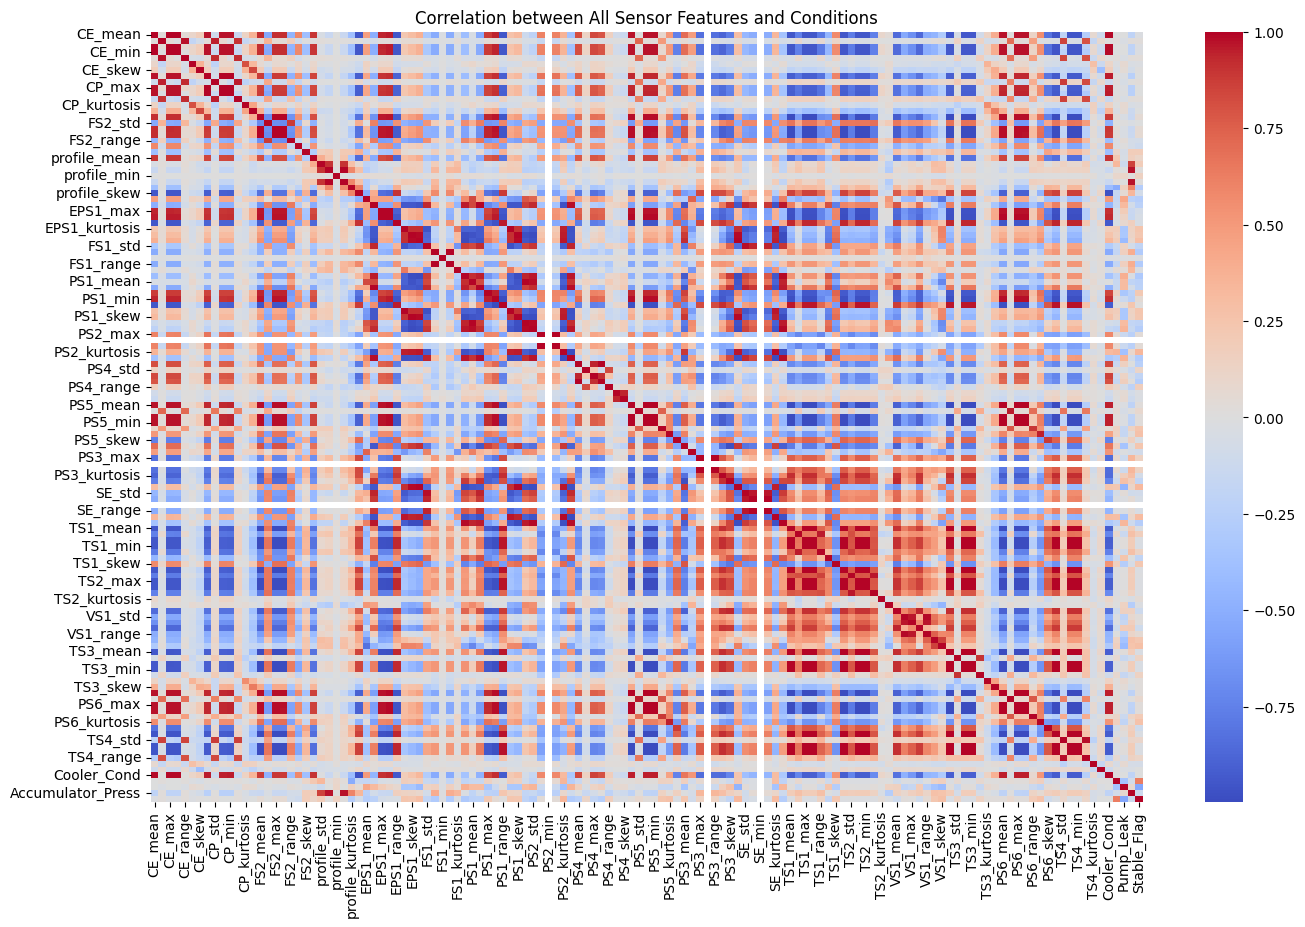

In [23]:
corr = full_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation between All Sensor Features and Conditions")
plt.show()


Shows relationships between all 126+ sensor features and target conditions. Identifies which sensors are related and which features might be redundant.

# **Target Correlation Heatmap**

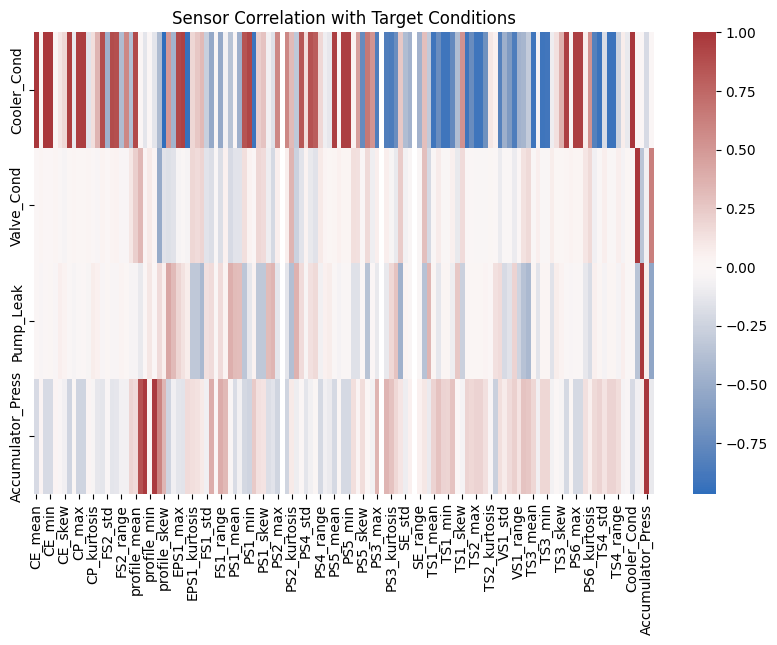

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(full_df.corr()[['Cooler_Cond','Valve_Cond','Pump_Leak','Accumulator_Press']].T,
            annot=False, cmap='vlag', center=0)
plt.title("Sensor Correlation with Target Conditions")
plt.show()


# **Pairplot with Cooler Condition**

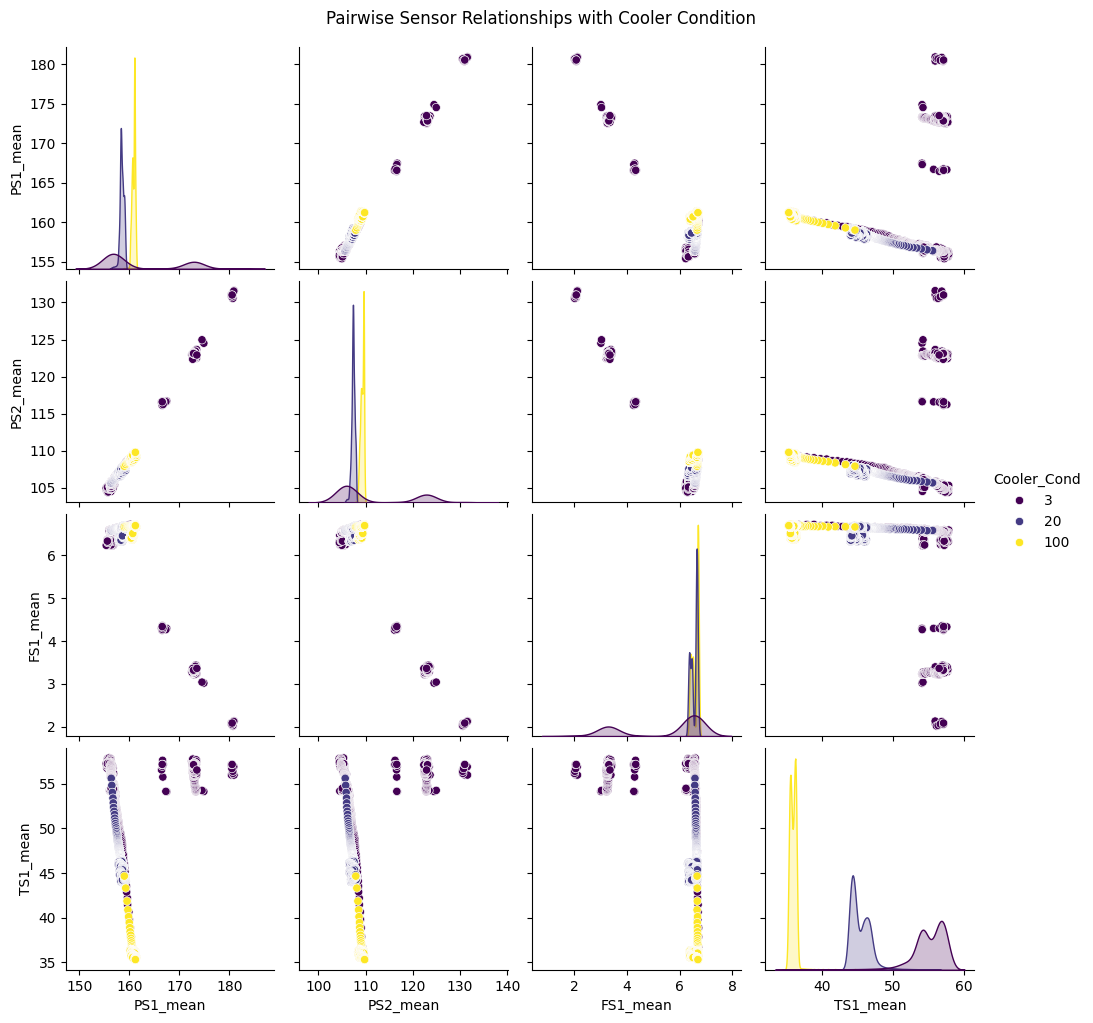

In [25]:
subset_cols = ['PS1_mean', 'PS2_mean', 'FS1_mean', 'TS1_mean', 'Cooler_Cond']
sns.pairplot(full_df[subset_cols], hue='Cooler_Cond', palette='viridis')
plt.suptitle("Pairwise Sensor Relationships with Cooler Condition", y=1.02)
plt.show()


Shows how PS1, PS2, FS1, and TS1 mean values relate to each other under different cooler conditions (3%, 20%, 100%). Helps visualize if cooler degradation creates distinct patterns.


# **Pump Leak vs PS3 Pressure**

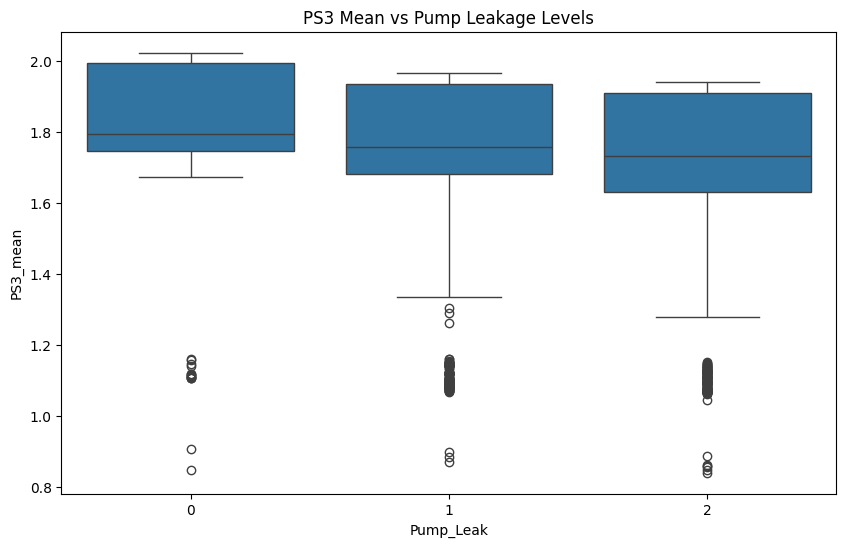

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Pump_Leak', y='PS3_mean', data=full_df)
plt.title("PS3 Mean vs Pump Leakage Levels")
plt.show()


 Box plots showing PS3 mean pressure at different pump leakage levels (0, 1, 2) As pump leakage increases (0→1→2), PS3 pressure changes. This confirms PS3 is a good indicator for detecting internal pump leakage.


# ** Pump Leakage Distribution**

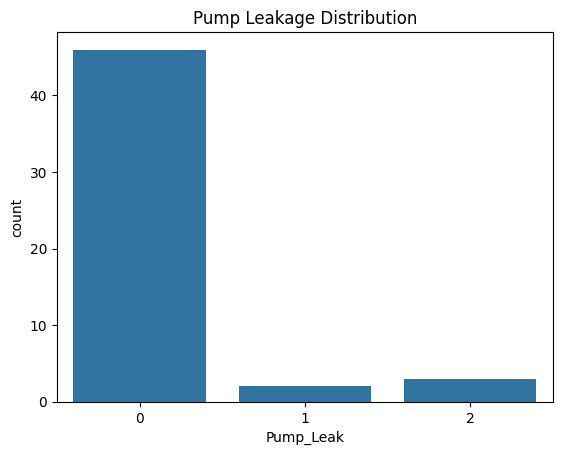

In [10]:
sns.countplot(x='Pump_Leak', data=combined_df)
plt.title("Pump Leakage Distribution")
plt.show()




Count plot showing frequency of each leakage level. Shows class imbalance - how many cycles had no leakage (0), weak leakage (1), or severe leakage (2). Important for understanding dataset composition.


# **PCA Visualization**

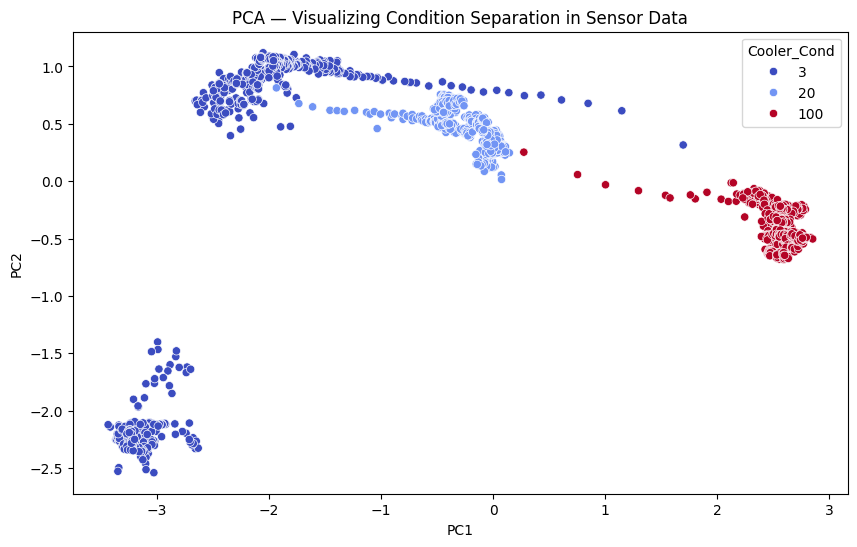

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(features_df)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    'PC1': pca_result[:,0],
    'PC2': pca_result[:,1],
    'Cooler_Cond': profile_df['Cooler_Cond']
})

plt.figure(figsize=(10,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cooler_Cond', data=pca_df, palette='coolwarm')
plt.title("PCA — Visualizing Condition Separation in Sensor Data")
plt.show()


2D scatter plot of first two principal components colored by cooler condition

Reduced 126+ features to 2 dimensions while preserving variance. Different cooler conditions (3%, 20%, 100%) show some separation, indicating sensor data contains information about cooler health.

# **Top 15 Features Correlated with Cooler Condition**

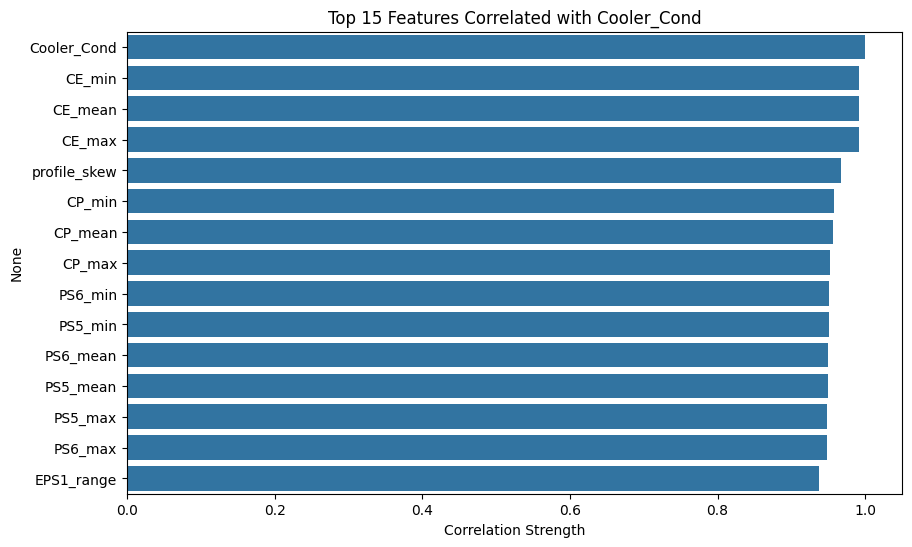

In [30]:
target = 'Cooler_Cond'
corr_scores = full_df.corr()[target].abs().sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
sns.barplot(x=corr_scores.values, y=corr_scores.index)
plt.title(f"Top 15 Features Correlated with {target}")
plt.xlabel('Correlation Strength')
plt.show()


 Bar plot showing strongest correlations.

 Identifies the most important sensor features for predicting cooler condition. Top features likely include cooling efficiency (CE), cooling power (CP), and temperature sensors.

# **Stability vs Cooler Condition**

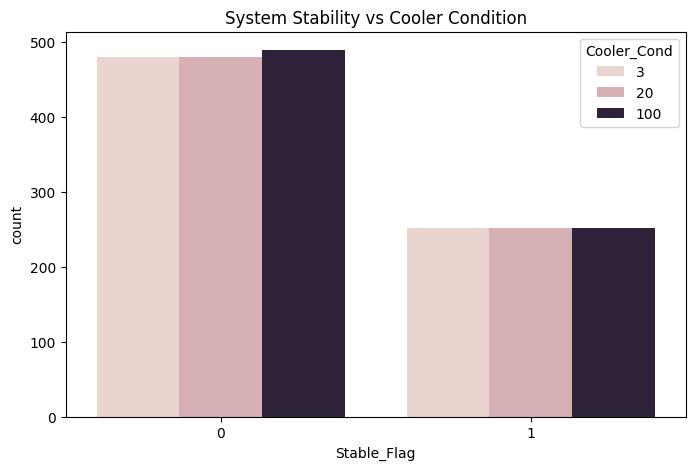

In [31]:
plt.figure(figsize=(8,5))
sns.countplot(x='Stable_Flag', hue='Cooler_Cond', data=profile_df)
plt.title("System Stability vs Cooler Condition")
plt.show()


Count plot showing stable flag distribution across cooler conditions

Checks if system stability (0=stable, 1=unstable) is affected by cooler condition. Most cycles should be stable (flag=0) for reliable measurements.


# **PS1 Pressure vs Cooler Condition**

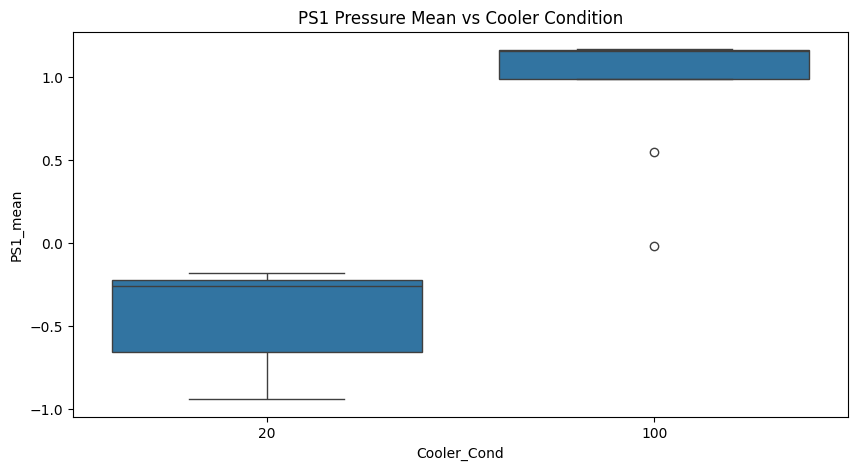

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Cooler_Cond', y='PS1_mean', data=combined_df)
plt.title("PS1 Pressure Mean vs Cooler Condition")
plt.show()


Box plot showing PS1 mean distribution for each cooler condition level.

Shows how primary pressure (PS1) varies with cooler health. Failing coolers (3%) may show different pressure patterns than healthy ones (100%).

# Multi-Sensor Time Series

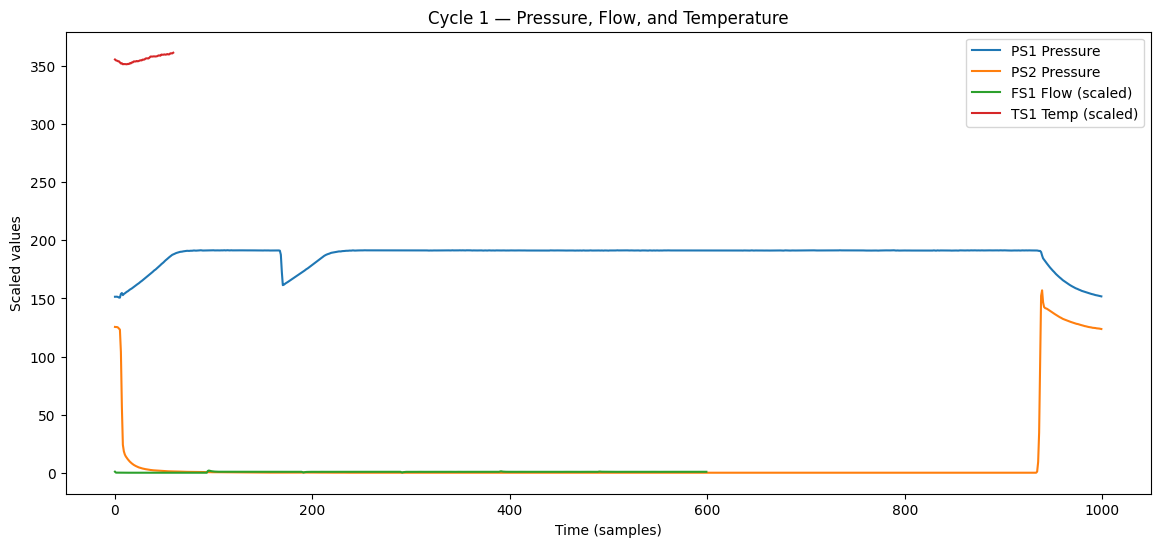

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

plt.figure(figsize=(14,6))
plt.plot(sensor_data['PS1'].iloc[0, :1000], label='PS1 Pressure')
plt.plot(sensor_data['PS2'].iloc[0, :1000], label='PS2 Pressure')
plt.plot(sensor_data['FS1'].iloc[0, :1000]*0.1, label='FS1 Flow (scaled)')
plt.plot(sensor_data['TS1'].iloc[0, :1000]*10, label='TS1 Temp (scaled)')
plt.title("Cycle 1 — Pressure, Flow, and Temperature")
plt.xlabel("Time (samples)")
plt.ylabel("Scaled values")
plt.legend()
plt.show()


 Line plot showing PS1, PS2, FS1, TS1 during first cycle.

  Visualizes how pressure, flow, and temperature change together during one 60-second cycle. Shows the dynamic behavior of the hydraulic system.


# **PS1 Averaged by Cooler Condition**

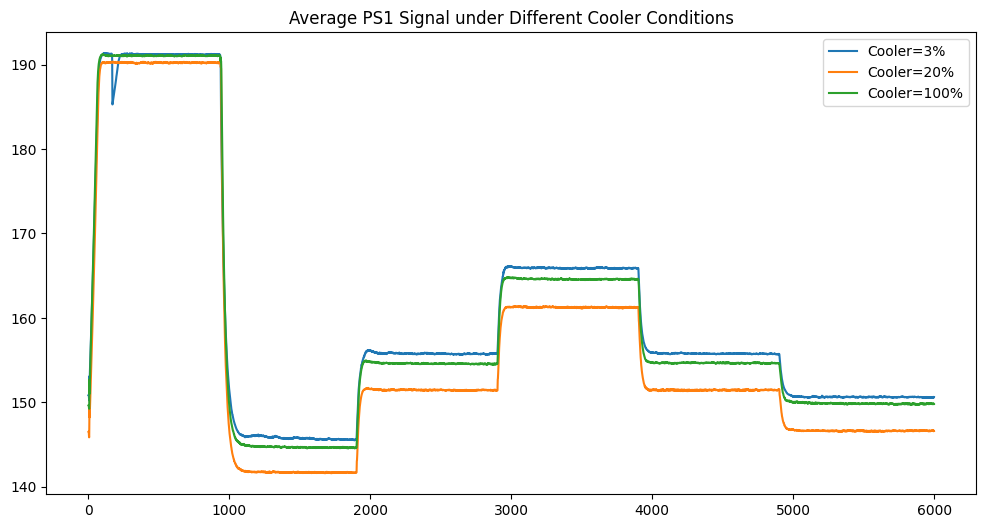

In [34]:
plt.figure(figsize=(12,6))
for cond in sorted(profile_df['Cooler_Cond'].unique()):
    idx = profile_df[profile_df['Cooler_Cond']==cond].index[:5]  # 5 examples per condition
    avg = sensor_data['PS1'].iloc[idx].mean(axis=0)
    plt.plot(avg, label=f'Cooler={cond}%')
plt.title("Average PS1 Signal under Different Cooler Conditions")
plt.legend()
plt.show()


Multiple line plots showing average PS1 signal for each cooler condition.

 Different cooler conditions produce noticeably different average pressure patterns. This confirms cooler health affects system pressure dynamics.


# **Sensor Inter-Correlation Heatmap**

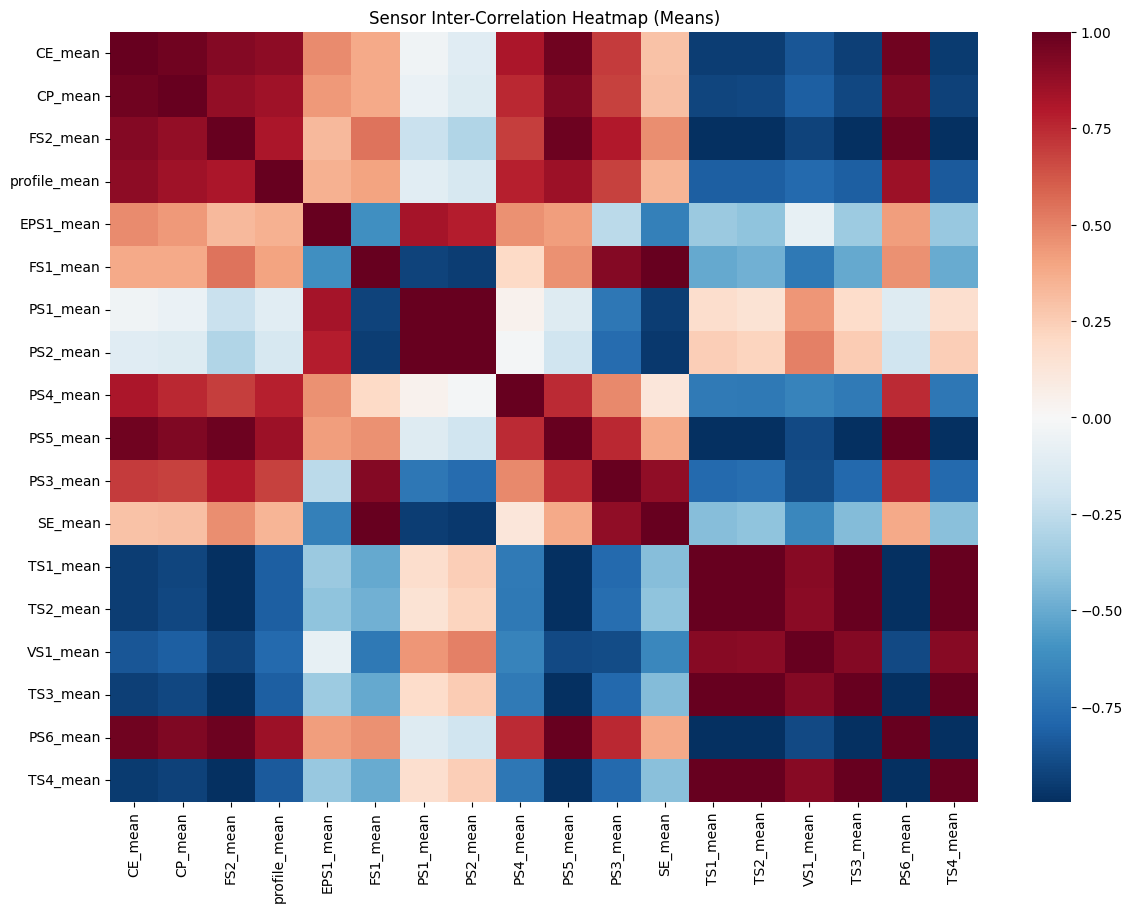

In [35]:
plt.figure(figsize=(14,10))
sns.heatmap(full_df.filter(like='_mean').corr(), cmap='RdBu_r', center=0)
plt.title("Sensor Inter-Correlation Heatmap (Means)")
plt.show()


Heatmap of correlations between all sensor mean values. Identifies which sensors measure related phenomena. Highly correlated sensors might be redundant; negatively correlated sensors might indicate opposing system behaviors.


# t-SNE Visualization

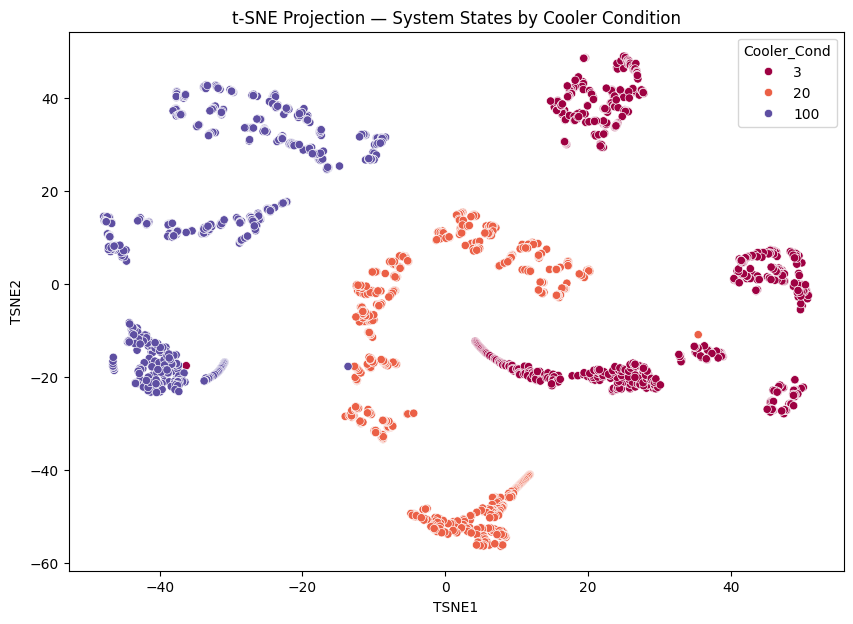

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(full_df.filter(like='_mean'))
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_res = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(tsne_res, columns=['TSNE1', 'TSNE2'])
tsne_df['Cooler_Cond'] = full_df['Cooler_Cond']

plt.figure(figsize=(10,7))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cooler_Cond', palette='Spectral')
plt.title("t-SNE Projection — System States by Cooler Condition")
plt.show()


# ** Parallel Coordinates Plot**

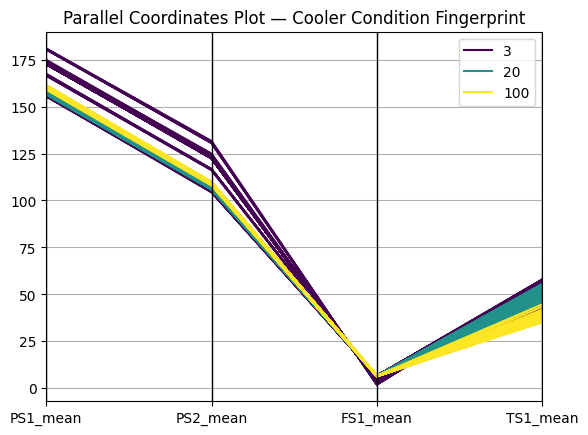

In [37]:
from pandas.plotting import parallel_coordinates

feat_cols = ['PS1_mean','PS2_mean','FS1_mean','TS1_mean','Cooler_Cond']
parallel_coordinates(full_df[feat_cols], 'Cooler_Cond', colormap='viridis')
plt.title('Parallel Coordinates Plot — Cooler Condition Fingerprint')
plt.show()


 Parallel coordinates showing PS1, PS2, FS1, TS1 means across cooler conditions. Multi-dimensional visualization showing "fingerprints" for each cooler condition. Each line represents one cycle; different colors represent different cooler conditions.


# ** Top Correlated Features for All Targets**

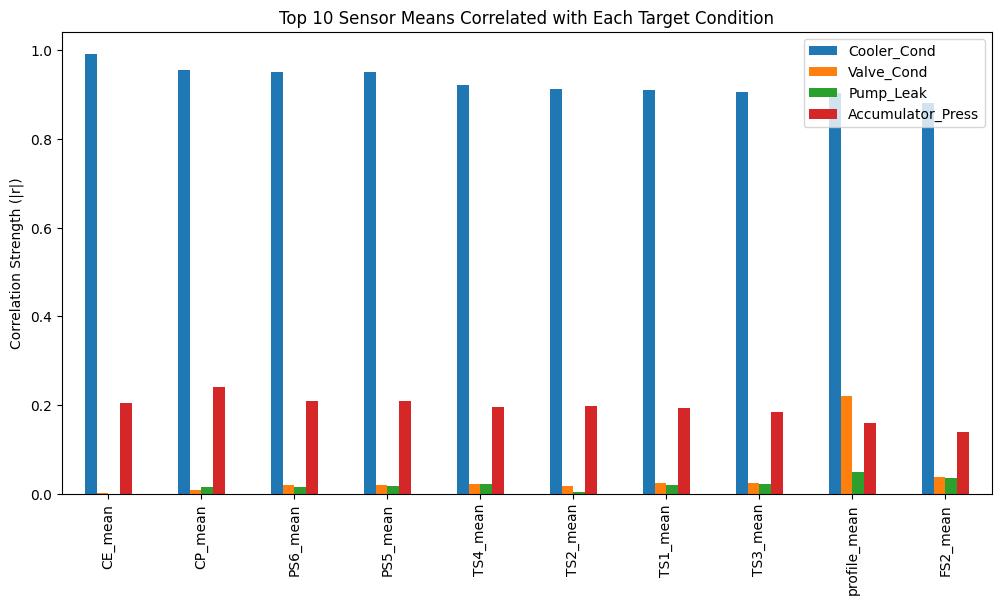

In [38]:
targets = ['Cooler_Cond','Valve_Cond','Pump_Leak','Accumulator_Press']
sensor_means = full_df.filter(like='_mean')
corrs = pd.DataFrame({t: sensor_means.corrwith(full_df[t]) for t in targets})
corrs.abs().nlargest(10, 'Cooler_Cond').plot(kind='bar', figsize=(12,6))
plt.title("Top 10 Sensor Means Correlated with Each Target Condition")
plt.ylabel("Correlation Strength (|r|)")
plt.show()


 Bar plot showing top 10 sensor means correlated with each of 4 target conditions. Comprehensive view of which sensors are most important for predicting each component's health. Helps prioritize sensors for maintenance monitoring.

# **PS3 Variability vs Pump Leak**

/tmp/ipython-input-2594724156.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Pump_Leak', y='PS3_std', data=full_df, palette='mako')


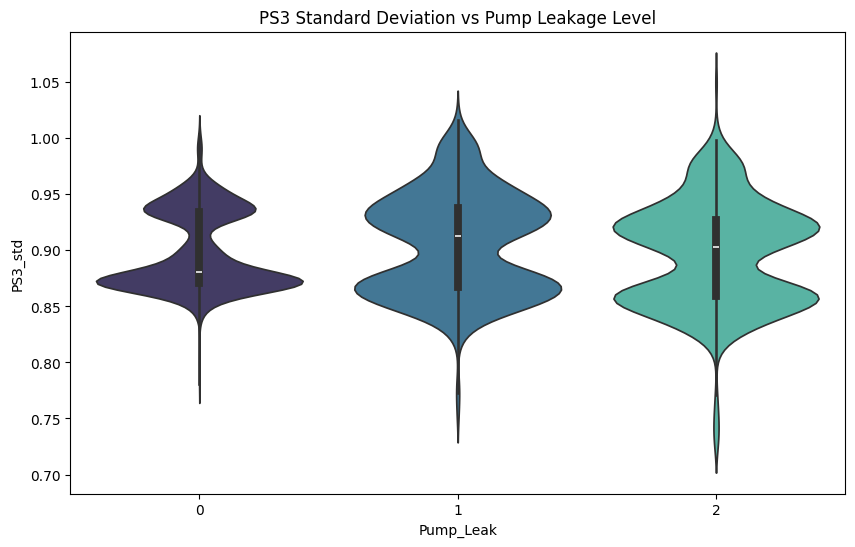

In [39]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Pump_Leak', y='PS3_std', data=full_df, palette='mako')
plt.title("PS3 Standard Deviation vs Pump Leakage Level")
plt.show()


Violin plot showing PS3 standard deviation distribution for each pump leak level. Pump leakage not only changes average PS3 pressure but also increases pressure variability (higher std). Leaking pumps produce less stable pressure.

# **Anomaly Detection with Control Chart**

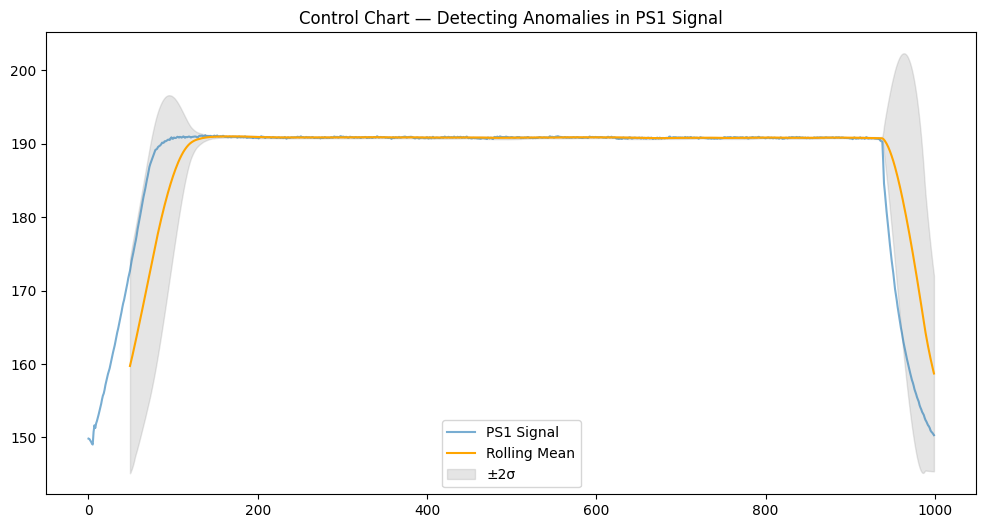

In [40]:
sensor_signal = sensor_data['PS1'].iloc[10, :1000]
rolling_mean = sensor_signal.rolling(window=50).mean()
rolling_std = sensor_signal.rolling(window=50).std()
upper = rolling_mean + 2*rolling_std
lower = rolling_mean - 2*rolling_std

plt.figure(figsize=(12,6))
plt.plot(sensor_signal, label='PS1 Signal', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.fill_between(range(len(sensor_signal)), lower, upper, color='gray', alpha=0.2, label='±2σ')
plt.legend()
plt.title("Control Chart — Detecting Anomalies in PS1 Signal")
plt.show()


 Time series with rolling mean and ±2σ bands. Statistical process control chart for PS1. Points outside the gray zone (±2σ) are potential anomalies. Useful for real-time fault detection.


# ** Average Sensor Profile per Cooler Condition**

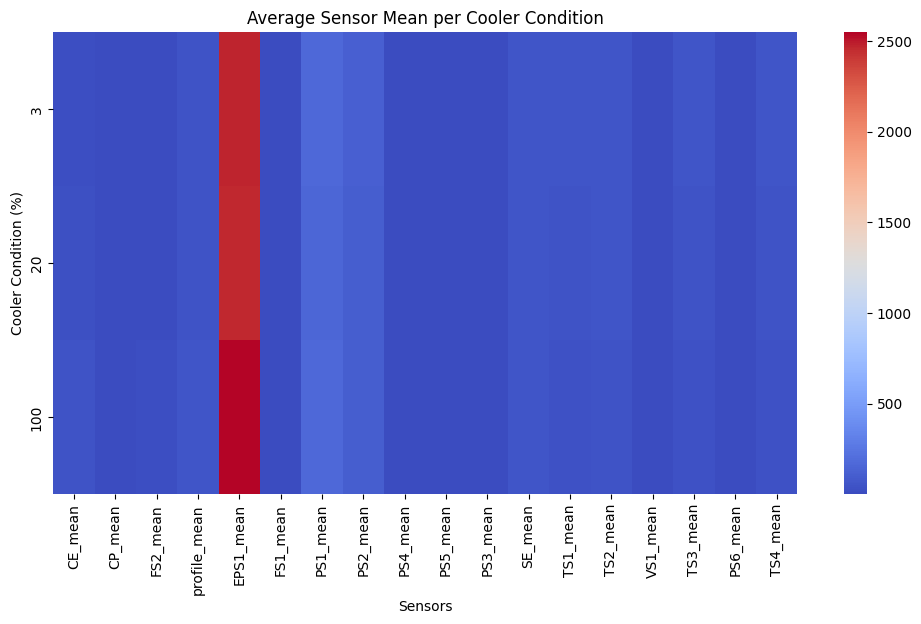

In [41]:
avg_by_condition = full_df.groupby('Cooler_Cond').mean().filter(like='_mean')
plt.figure(figsize=(12,6))
sns.heatmap(avg_by_condition, cmap='coolwarm', annot=False)
plt.title("Average Sensor Mean per Cooler Condition")
plt.xlabel("Sensors")
plt.ylabel("Cooler Condition (%)")
plt.show()


Heatmap showing mean sensor values grouped by cooler condition. Creates "signature" profiles for each cooler condition. Shows which sensors increase/decrease as cooler degrades from 100% → 20% → 3%.



# **Advanced Pairplot with Multiple Plot Types**

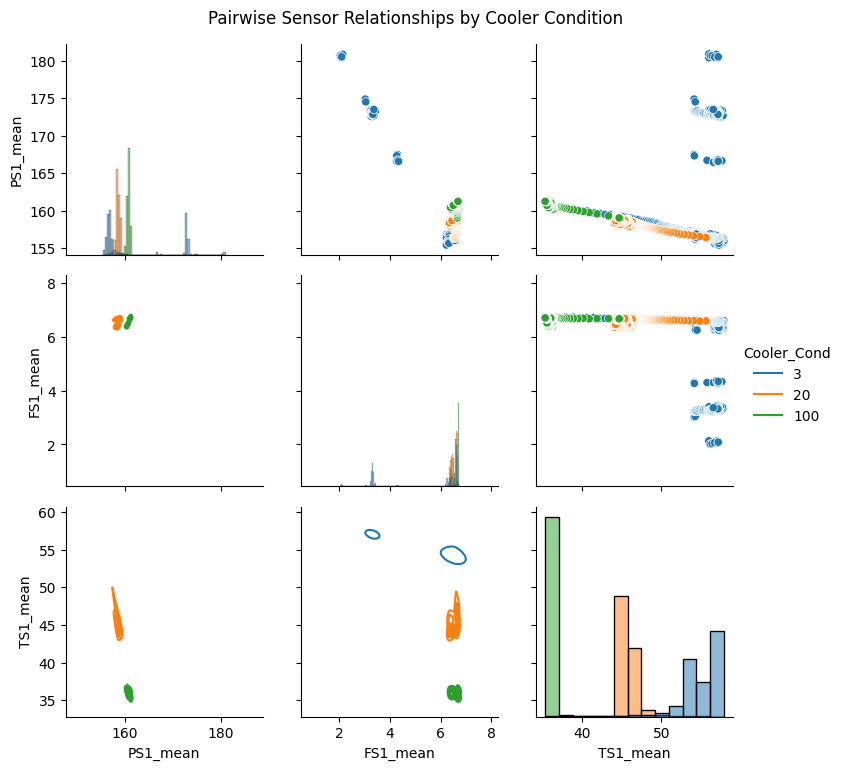

In [43]:
subset = full_df[['PS1_mean','FS1_mean','TS1_mean','Cooler_Cond']]
g = sns.PairGrid(subset, hue='Cooler_Cond', palette='tab10')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
g.add_legend()
plt.suptitle("Pairwise Sensor Relationships by Cooler Condition", y=1.02)
plt.show()


Grid showing scatter plots (upper), KDE plots (lower), and histograms (diagonal)

Comprehensive pairwise analysis showing:
- Upper: Individual data point relationships
- Lower: Probability density relationships  
- Diagonal: Distribution of each sensor
All colored by cooler condition for pattern identification.

# **Cooler Condition Over Time**

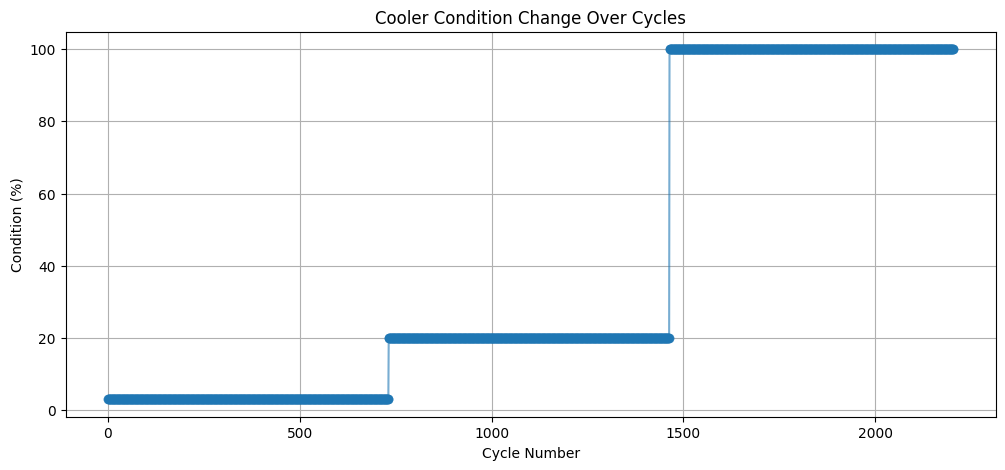

In [47]:
plt.figure(figsize=(12,5))
plt.plot(profile_df['Cooler_Cond'], marker='o', alpha=0.6)
plt.title("Cooler Condition Change Over Cycles")
plt.xlabel("Cycle Number")
plt.ylabel("Condition (%)")
plt.grid(True)
plt.show()


Line plot showing cooler condition changes across 2,205 cycles. Shows experimental design - cooler condition was systematically varied during testing. Visualizes the sequence of different cooler health states tested.


In [50]:
# Import all necessary libraries for MLOps pipeline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
from datetime import datetime

print(" All libraries imported successfully!")
print(f"Pipeline initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


 All libraries imported successfully!
Pipeline initialized at: 2025-10-14 11:53:36


In [51]:
# 1 ANALYZE TARGET VARIABLES - Understanding the Classification Problem
print("="*80)
print("🎯 TARGET VARIABLE ANALYSIS - Multi-Class Classification")
print("="*80)

targets = ['Cooler_Cond', 'Valve_Cond', 'Pump_Leak', 'Accumulator_Press']

for target in targets:
    print(f"\n📊 {target}:")
    value_counts = full_df[target].value_counts().sort_index()
    print(f"   Classes: {value_counts.index.tolist()}")
    print(f"   Distribution:\n{value_counts}")
    print(f"   Total samples: {len(full_df)}")
    print(f"   Class imbalance ratio: {value_counts.max() / value_counts.min():.2f}x")

print("\n" + "="*80)
print(" All targets are MULTI-CLASS CLASSIFICATION problems")
print("="*80)


🎯 TARGET VARIABLE ANALYSIS - Multi-Class Classification

📊 Cooler_Cond:
   Classes: [3, 20, 100]
   Distribution:
Cooler_Cond
3      732
20     732
100    741
Name: count, dtype: int64
   Total samples: 2205
   Class imbalance ratio: 1.01x

📊 Valve_Cond:
   Classes: [73, 80, 90, 100]
   Distribution:
Valve_Cond
73      360
80      360
90      360
100    1125
Name: count, dtype: int64
   Total samples: 2205
   Class imbalance ratio: 3.12x

📊 Pump_Leak:
   Classes: [0, 1, 2]
   Distribution:
Pump_Leak
0    1221
1     492
2     492
Name: count, dtype: int64
   Total samples: 2205
   Class imbalance ratio: 2.48x

📊 Accumulator_Press:
   Classes: [90, 100, 115, 130]
   Distribution:
Accumulator_Press
90     808
100    399
115    399
130    599
Name: count, dtype: int64
   Total samples: 2205
   Class imbalance ratio: 2.03x

 All targets are MULTI-CLASS CLASSIFICATION problems


FEATURE SELECTION - Correlation-Based Method

Total features available: 126
 Total samples: 2205

 Target: Cooler_Cond

🏆 Top 20 Features (by correlation):
    1. CE_min                         | Correlation: 0.9920
    2. CE_mean                        | Correlation: 0.9919
    3. CE_max                         | Correlation: 0.9912
    4. profile_skew                   | Correlation: 0.9678
    5. CP_min                         | Correlation: 0.9572
    6. CP_mean                        | Correlation: 0.9562
    7. CP_max                         | Correlation: 0.9525
    8. PS6_min                        | Correlation: 0.9513
    9. PS5_min                        | Correlation: 0.9509
   10. PS6_mean                       | Correlation: 0.9503
   11. PS5_mean                       | Correlation: 0.9500
   12. PS5_max                        | Correlation: 0.9488
   13. PS6_max                        | Correlation: 0.9487
   14. EPS1_range                     | Correlation: 0.9374
   1

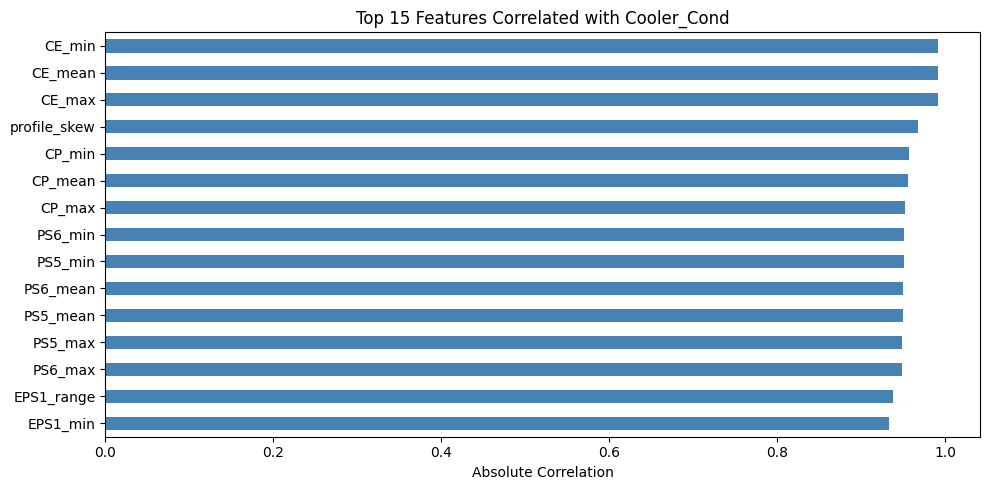


 Target: Valve_Cond

🏆 Top 20 Features (by correlation):
    1. profile_kurtosis               | Correlation: 0.5189
    2. PS2_kurtosis                   | Correlation: 0.3499
    3. profile_std                    | Correlation: 0.3351
    4. SE_kurtosis                    | Correlation: 0.2964
    5. PS2_skew                       | Correlation: 0.2566
    6. SE_mean                        | Correlation: 0.2314
    7. profile_mean                   | Correlation: 0.2207
    8. SE_skew                        | Correlation: 0.2133
    9. PS2_std                        | Correlation: 0.2074
   10. FS1_skew                       | Correlation: 0.2003
   11. FS1_mean                       | Correlation: 0.1901
   12. FS1_max                        | Correlation: 0.1819
   13. FS1_range                      | Correlation: 0.1819
   14. EPS1_kurtosis                  | Correlation: 0.1806
   15. PS1_kurtosis                   | Correlation: 0.1795
   16. EPS1_mean                      | Co

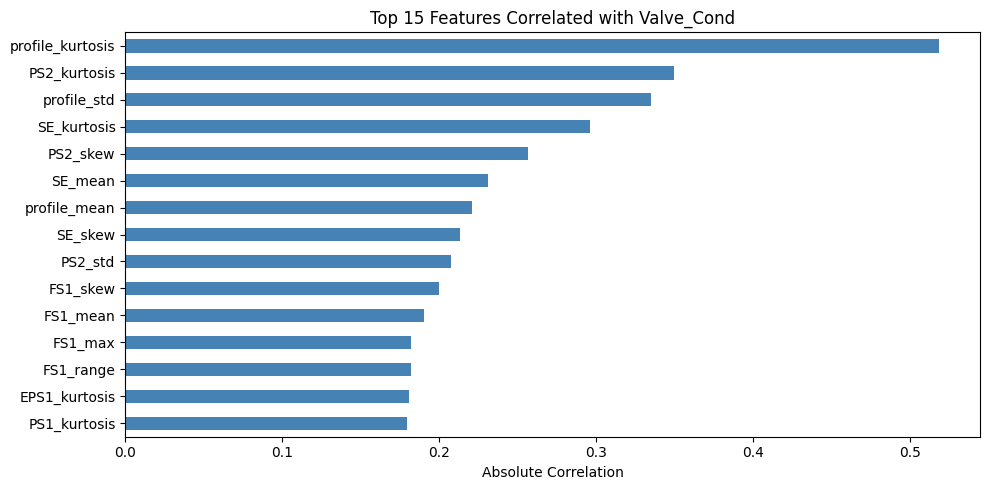


 Target: Pump_Leak

🏆 Top 20 Features (by correlation):
    1. SE_mean                        | Correlation: 0.4692
    2. EPS1_mean                      | Correlation: 0.4263
    3. VS1_skew                       | Correlation: 0.4219
    4. FS1_mean                       | Correlation: 0.4217
    5. FS1_skew                       | Correlation: 0.3844
    6. PS2_kurtosis                   | Correlation: 0.3794
    7. VS1_kurtosis                   | Correlation: 0.3639
    8. SE_kurtosis                    | Correlation: 0.3610
    9. PS2_skew                       | Correlation: 0.3571
   10. PS3_mean                       | Correlation: 0.3551
   11. PS2_std                        | Correlation: 0.3449
   12. SE_skew                        | Correlation: 0.3432
   13. PS1_max                        | Correlation: 0.3315
   14. EPS1_kurtosis                  | Correlation: 0.3266
   15. EPS1_skew                      | Correlation: 0.3255
   16. PS1_kurtosis                   | Cor

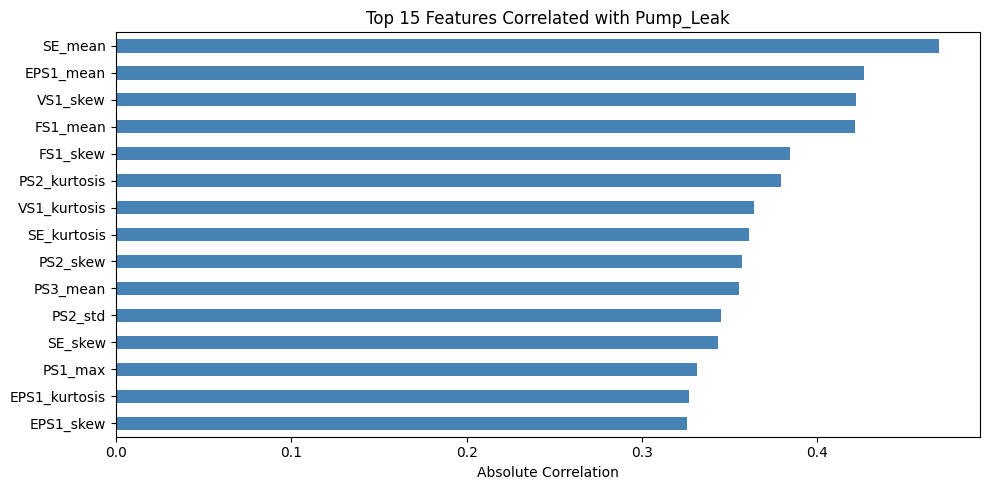


 Target: Accumulator_Press

🏆 Top 20 Features (by correlation):
    1. profile_max                    | Correlation: 0.9697
    2. profile_range                  | Correlation: 0.9697
    3. profile_std                    | Correlation: 0.8578
    4. profile_kurtosis               | Correlation: 0.6016
    5. FS1_max                        | Correlation: 0.3971
    6. FS1_range                      | Correlation: 0.3971
    7. profile_skew                   | Correlation: 0.3441
    8. PS3_range                      | Correlation: 0.3424
    9. PS3_max                        | Correlation: 0.3424
   10. FS1_kurtosis                   | Correlation: 0.3304
   11. PS3_kurtosis                   | Correlation: 0.2849
   12. TS1_range                      | Correlation: 0.2812
   13. TS1_std                        | Correlation: 0.2778
   14. VS1_kurtosis                   | Correlation: 0.2717
   15. TS2_skew                       | Correlation: 0.2685
   16. VS1_skew                    

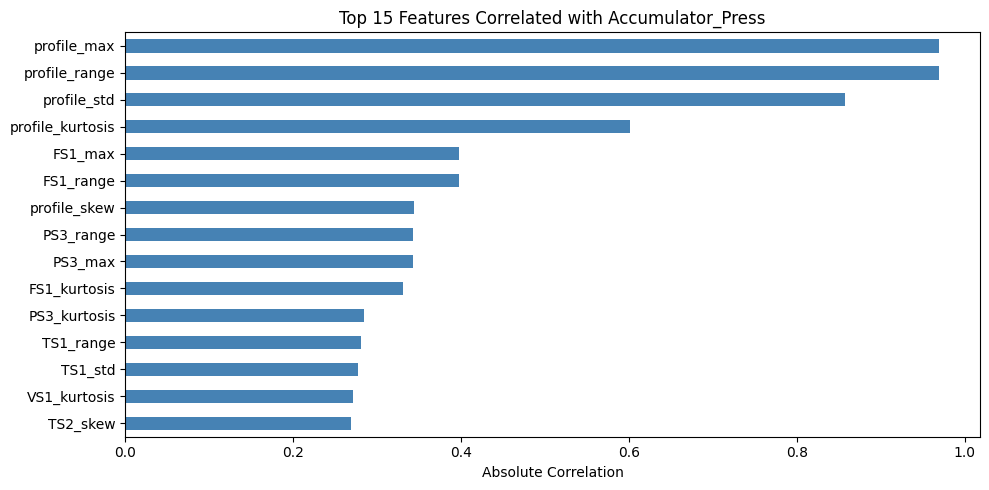


 Feature selection completed for all targets!


In [52]:
# 2. FEATURE SELECTION - Top 15-20 Correlated Features per Target
print("="*80)
print("FEATURE SELECTION - Correlation-Based Method")
print("="*80)

# Prepare feature matrix (exclude target columns and stable flag)
feature_cols = [col for col in full_df.columns if col not in targets + ['Stable_Flag']]
X_all = full_df[feature_cols]

print(f"\nTotal features available: {len(feature_cols)}")
print(f" Total samples: {len(X_all)}")

# Store top features for each target
top_features_dict = {}

for target in targets:
    print(f"\n{'='*60}")
    print(f" Target: {target}")
    print(f"{'='*60}")

    # Calculate correlation with target
    correlations = X_all.corrwith(full_df[target]).abs().sort_values(ascending=False)

    # Select top 20 features
    top_20_features = correlations.head(20)
    top_features_dict[target] = top_20_features.index.tolist()

    print(f"\n🏆 Top 20 Features (by correlation):")
    for i, (feat, corr) in enumerate(top_20_features.items(), 1):
        print(f"   {i:2d}. {feat:30s} | Correlation: {corr:.4f}")

    # Visualize top 15
    plt.figure(figsize=(10, 5))
    top_20_features.head(15).plot(kind='barh', color='steelblue')
    plt.xlabel('Absolute Correlation')
    plt.title(f'Top 15 Features Correlated with {target}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print(" Feature selection completed for all targets!")
print("="*80)


📉 PCA DIMENSIONALITY REDUCTION

📊 PCA with 10 components: 83.64% variance explained

📊 PCA with 20 components: 92.92% variance explained

📊 PCA with 30 components: 97.42% variance explained

📊 PCA with 50 components: 99.68% variance explained


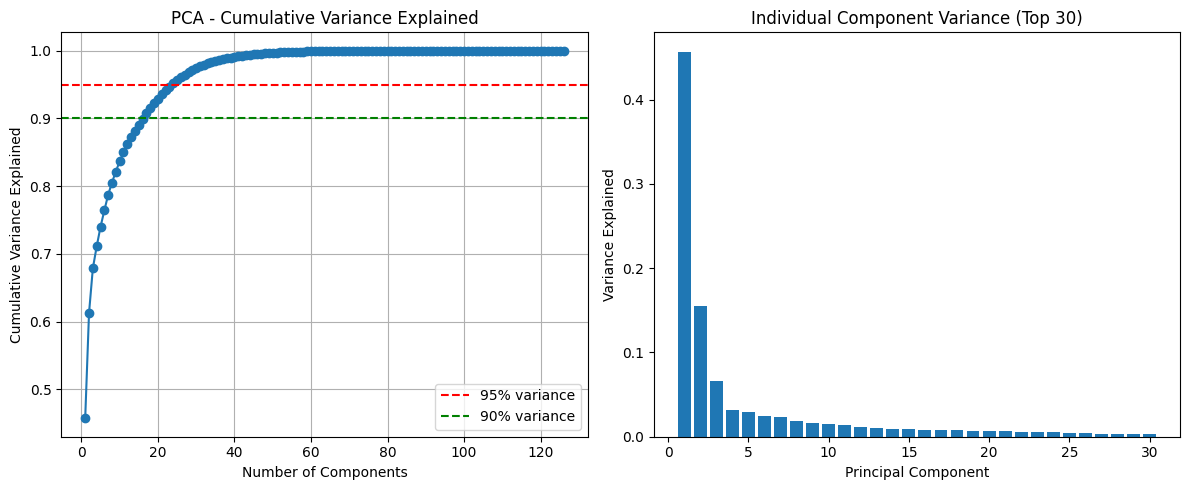


✅ Optimal PCA components for 95% variance: 24


In [53]:
# 3️⃣ PCA DIMENSIONALITY REDUCTION
print("="*80)
print("📉 PCA DIMENSIONALITY REDUCTION")
print("="*80)

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# Apply PCA with different n_components
n_components_list = [10, 20, 30, 50]
pca_results = {}

for n_comp in n_components_list:
    pca = PCA(n_components=n_comp, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    variance_explained = pca.explained_variance_ratio_.sum()
    pca_results[n_comp] = {
        'variance_explained': variance_explained,
        'pca_object': pca
    }
    print(f"\n📊 PCA with {n_comp:2d} components: {variance_explained*100:.2f}% variance explained")

# Visualize variance explained
plt.figure(figsize=(12, 5))

# Plot 1: Cumulative variance
plt.subplot(1, 2, 1)
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumsum_variance)+1), cumsum_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA - Cumulative Variance Explained')
plt.legend()
plt.grid(True)

# Plot 2: Individual component variance
plt.subplot(1, 2, 2)
plt.bar(range(1, 31), pca_full.explained_variance_ratio_[:30])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Individual Component Variance (Top 30)')
plt.tight_layout()
plt.show()

# Optimal number of components (95% variance)
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
print(f"\n✅ Optimal PCA components for 95% variance: {n_components_95}")
print("="*80)


In [54]:
# 4️ MLOPS PIPELINE BUILDER - Modular & Reusable
print("="*80)
print("🏗️ BUILDING MLOPS PIPELINE - Best Practices")
print("="*80)

def create_ml_pipeline(model, use_pca=False, n_components=20, use_smote=True):
    """
    Create a complete ML pipeline with preprocessing, SMOTE, and model

    Args:
        model: sklearn classifier
        use_pca: whether to use PCA
        n_components: number of PCA components
        use_smote: whether to use SMOTE for class imbalance

    Returns:
        pipeline: sklearn/imblearn pipeline
    """
    steps = []

    # Step 1: Scaling
    steps.append(('scaler', StandardScaler()))

    # Step 2: PCA (optional)
    if use_pca:
        steps.append(('pca', PCA(n_components=n_components, random_state=42)))

    # Step 3: SMOTE (optional)
    if use_smote:
        steps.append(('smote', SMOTE(random_state=42, k_neighbors=3)))
        pipeline = ImbPipeline(steps + [('classifier', model)])
    else:
        steps.append(('classifier', model))
        pipeline = Pipeline(steps)

    return pipeline

# Example: Create different pipeline configurations
print("\n✅ Pipeline configurations available:")
print("   1. Full Pipeline: Scaler → PCA → SMOTE → Classifier")
print("   2. No PCA: Scaler → SMOTE → Classifier")
print("   3. No SMOTE: Scaler → PCA → Classifier")
print("   4. Simple: Scaler → Classifier")

print("\n📦 MLOps Features:")
print("   ✓ Reproducible (random_state=42)")
print("   ✓ Modular (easily swap components)")
print("   ✓ Handles imbalance (SMOTE)")
print("   ✓ Dimensionality reduction (PCA)")
print("   ✓ Proper scaling (StandardScaler)")
print("="*80)


🏗️ BUILDING MLOPS PIPELINE - Best Practices

✅ Pipeline configurations available:
   1. Full Pipeline: Scaler → PCA → SMOTE → Classifier
   2. No PCA: Scaler → SMOTE → Classifier
   3. No SMOTE: Scaler → PCA → Classifier
   4. Simple: Scaler → Classifier

📦 MLOps Features:
   ✓ Reproducible (random_state=42)
   ✓ Modular (easily swap components)
   ✓ Handles imbalance (SMOTE)
   ✓ Dimensionality reduction (PCA)
   ✓ Proper scaling (StandardScaler)


In [55]:
# 5️ TRAIN-TEST SPLIT & MODEL TRAINING
print("="*80)
print("🎓 MODEL TRAINING - Multi-Target Classification")
print("="*80)

# Choose target for demonstration (you can loop through all)
TARGET = 'Cooler_Cond'  # Change to: 'Valve_Cond', 'Pump_Leak', 'Accumulator_Press'

print(f"\n🎯 Training models for: {TARGET}")
print("="*60)

# Prepare data
X = X_all.copy()
y = full_df[TARGET].copy()

# Use top 20 features for this target
top_features = top_features_dict[TARGET]
X_selected = X[top_features]

print(f"\n📊 Data Shape:")
print(f"   Features (selected): {X_selected.shape}")
print(f"   Target: {y.shape}")
print(f"   Classes: {sorted(y.unique())}")

# Train-test split (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n📈 Split Info:")
print(f"   Train samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test samples:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Check class distribution in train/test
print(f"\n📊 Train set distribution:")
print(y_train.value_counts().sort_index())
print(f"\n📊 Test set distribution:")
print(y_test.value_counts().sort_index())

print("="*80)


🎓 MODEL TRAINING - Multi-Target Classification

🎯 Training models for: Cooler_Cond

📊 Data Shape:
   Features (selected): (2205, 20)
   Target: (2205,)
   Classes: [np.int64(3), np.int64(20), np.int64(100)]

📈 Split Info:
   Train samples: 1764 (80.0%)
   Test samples:  441 (20.0%)

📊 Train set distribution:
Cooler_Cond
3      585
20     586
100    593
Name: count, dtype: int64

📊 Test set distribution:
Cooler_Cond
3      147
20     146
100    148
Name: count, dtype: int64


In [58]:
# 6️ MODEL COMPARISON - Multiple Algorithms with Different Pipelines
print("="*80)
print("🏆 MODEL COMPARISON - Finding Best Configuration")
print("="*80)

# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42)
}

# Different pipeline configurations
configs = [
    {'name': 'Top20 + SMOTE', 'use_pca': False, 'use_smote': True},
    {'name': 'Top20 + PCA(20) + SMOTE', 'use_pca': True, 'n_components': 20, 'use_smote': True},
    {'name': 'Top20 Only', 'use_pca': False, 'use_smote': False},
]

# Store results
results = []

print(f"\n🔄 Training {len(models)} models x {len(configs)} configurations = {len(models)*len(configs)} experiments")
print("="*80)

for config in configs:
    print(f"\n{'='*60}")
    print(f"📦 Configuration: {config['name']}")
    print(f"{'='*60}")

    for model_name, model in models.items():
        # Create pipeline
        pipeline = create_ml_pipeline(
            model,
            use_pca=config.get('use_pca', False),
            n_components=config.get('n_components', 20),
            use_smote=config.get('use_smote', True)
        )

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_test)

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store results
        results.append({
            'Configuration': config['name'],
            'Model': model_name,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Pipeline': pipeline
        })

        print(f"   {model_name:20s} | Accuracy: {accuracy:.4f} | F1-Score: {f1:.4f}")

print("\n" + "="*80)
print("✅ Training completed!")
print("="*80)


🏆 MODEL COMPARISON - Finding Best Configuration

🔄 Training 4 models x 3 configurations = 12 experiments

📦 Configuration: Top20 + SMOTE
   Random Forest        | Accuracy: 1.0000 | F1-Score: 1.0000
   Gradient Boosting    | Accuracy: 1.0000 | F1-Score: 1.0000
   Logistic Regression  | Accuracy: 1.0000 | F1-Score: 1.0000
   SVM                  | Accuracy: 1.0000 | F1-Score: 1.0000

📦 Configuration: Top20 + PCA(20) + SMOTE
   Random Forest        | Accuracy: 1.0000 | F1-Score: 1.0000
   Gradient Boosting    | Accuracy: 1.0000 | F1-Score: 1.0000
   Logistic Regression  | Accuracy: 1.0000 | F1-Score: 1.0000
   SVM                  | Accuracy: 1.0000 | F1-Score: 1.0000

📦 Configuration: Top20 Only
   Random Forest        | Accuracy: 1.0000 | F1-Score: 1.0000
   Gradient Boosting    | Accuracy: 1.0000 | F1-Score: 1.0000
   Logistic Regression  | Accuracy: 1.0000 | F1-Score: 1.0000
   SVM                  | Accuracy: 1.0000 | F1-Score: 1.0000

✅ Training completed!


📊 RESULTS ANALYSIS

🏆 Top 10 Best Performing Models:
          Configuration               Model  Accuracy  F1-Score
          Top20 + SMOTE       Random Forest       1.0       1.0
          Top20 + SMOTE   Gradient Boosting       1.0       1.0
          Top20 + SMOTE Logistic Regression       1.0       1.0
          Top20 + SMOTE                 SVM       1.0       1.0
Top20 + PCA(20) + SMOTE       Random Forest       1.0       1.0
Top20 + PCA(20) + SMOTE   Gradient Boosting       1.0       1.0
Top20 + PCA(20) + SMOTE Logistic Regression       1.0       1.0
Top20 + PCA(20) + SMOTE                 SVM       1.0       1.0
             Top20 Only       Random Forest       1.0       1.0
             Top20 Only   Gradient Boosting       1.0       1.0

🥇 BEST MODEL:
   Configuration: Top20 + SMOTE
   Model: Random Forest
   Accuracy: 1.0000
   F1-Score: 1.0000


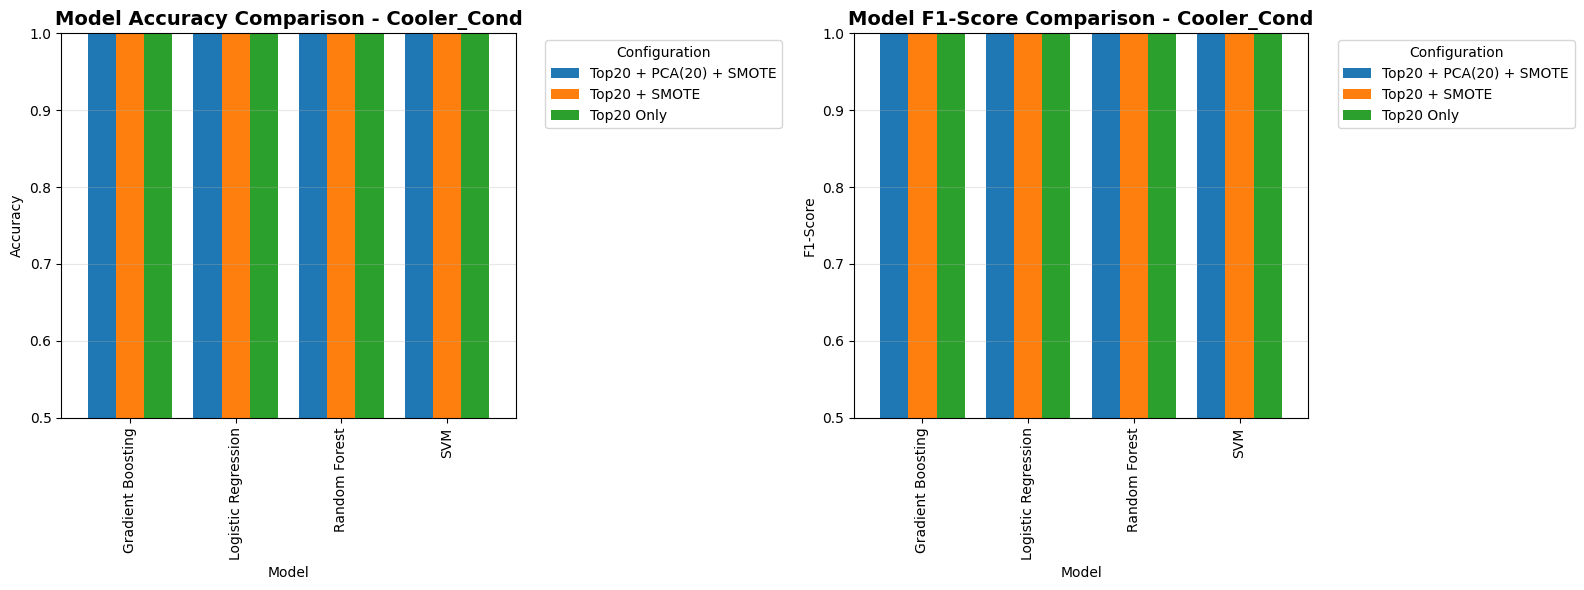


📈 Statistical Summary:
       Accuracy  F1-Score
count      12.0      12.0
mean        1.0       1.0
std         0.0       0.0
min         1.0       1.0
25%         1.0       1.0
50%         1.0       1.0
75%         1.0       1.0
max         1.0       1.0


In [59]:
# 7️ RESULTS ANALYSIS & VISUALIZATION
print("="*80)
print("📊 RESULTS ANALYSIS")
print("="*80)

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n🏆 Top 10 Best Performing Models:")
print("="*80)
print(results_df[['Configuration', 'Model', 'Accuracy', 'F1-Score']].head(10).to_string(index=False))

# Find best model
best_model = results_df.iloc[0]
print(f"\n{'='*80}")
print(f"🥇 BEST MODEL:")
print(f"   Configuration: {best_model['Configuration']}")
print(f"   Model: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"{'='*80}")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison
ax1 = axes[0]
pivot_acc = results_df.pivot(index='Model', columns='Configuration', values='Accuracy')
pivot_acc.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title(f'Model Accuracy Comparison - {TARGET}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Model')
ax1.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.5, 1.0])

# Plot 2: F1-Score comparison
ax2 = axes[1]
pivot_f1 = results_df.pivot(index='Model', columns='Configuration', values='F1-Score')
pivot_f1.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title(f'Model F1-Score Comparison - {TARGET}', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_xlabel('Model')
ax2.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.show()

# Statistical summary
print("\n📈 Statistical Summary:")
print("="*80)
print(results_df[['Accuracy', 'F1-Score']].describe())
print("="*80)


🔍 DETAILED EVALUATION - Best Model

📋 Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       147
          20       1.00      1.00      1.00       146
         100       1.00      1.00      1.00       148

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441


🔢 Confusion Matrix:
[[147   0   0]
 [  0 146   0]
 [  0   0 148]]


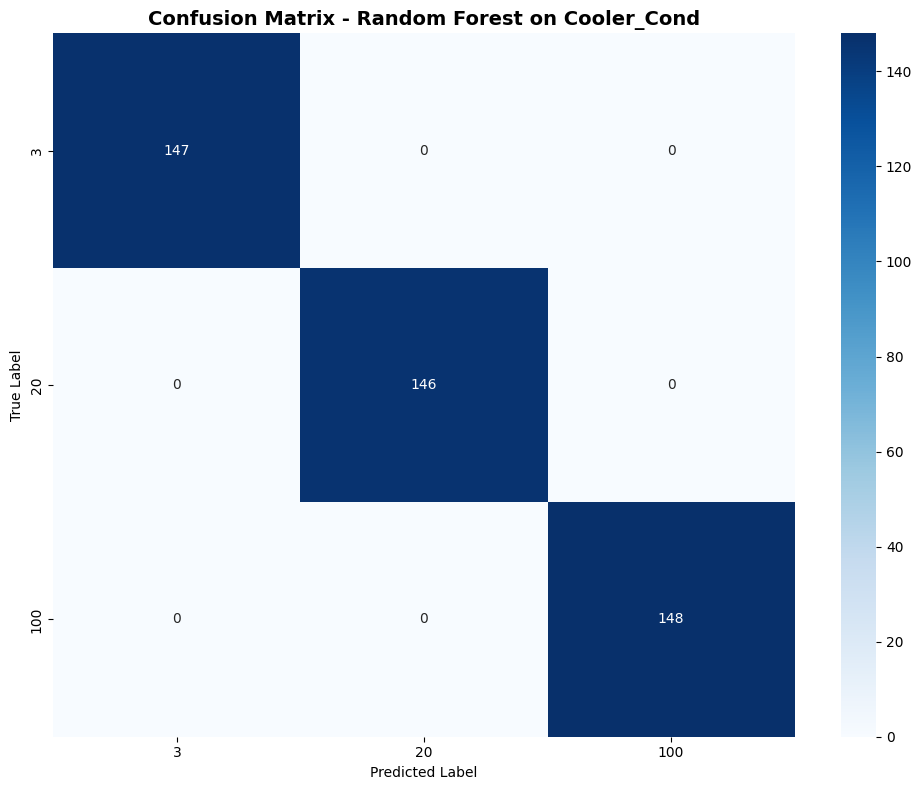


📊 Per-Class Performance:
   Class      3: Accuracy = 1.0000 (147/147)
   Class     20: Accuracy = 1.0000 (146/146)
   Class    100: Accuracy = 1.0000 (148/148)


In [60]:
# 8️ DETAILED EVALUATION - Best Model
print("="*80)
print("🔍 DETAILED EVALUATION - Best Model")
print("="*80)

# Get best pipeline
best_pipeline = best_model['Pipeline']

# Predictions
y_pred = best_pipeline.predict(X_test)

# Classification Report
print(f"\n📋 Classification Report:")
print("="*80)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n🔢 Confusion Matrix:")
print("="*80)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix - {best_model["Model"]} on {TARGET}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print(f"\n📊 Per-Class Performance:")
print("="*80)
for i, class_label in enumerate(sorted(y.unique())):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"   Class {class_label:6}: Accuracy = {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")
print("="*80)


🔄 CROSS-VALIDATION - 5-Fold Stratified

📊 Cross-Validation Results (5-Fold):
   Fold Scores: [1.         0.99773243 0.99773243 1.         0.99773243]
   Mean Accuracy: 0.9986 (+/- 0.0011)
   Min Accuracy:  0.9977
   Max Accuracy:  1.0000


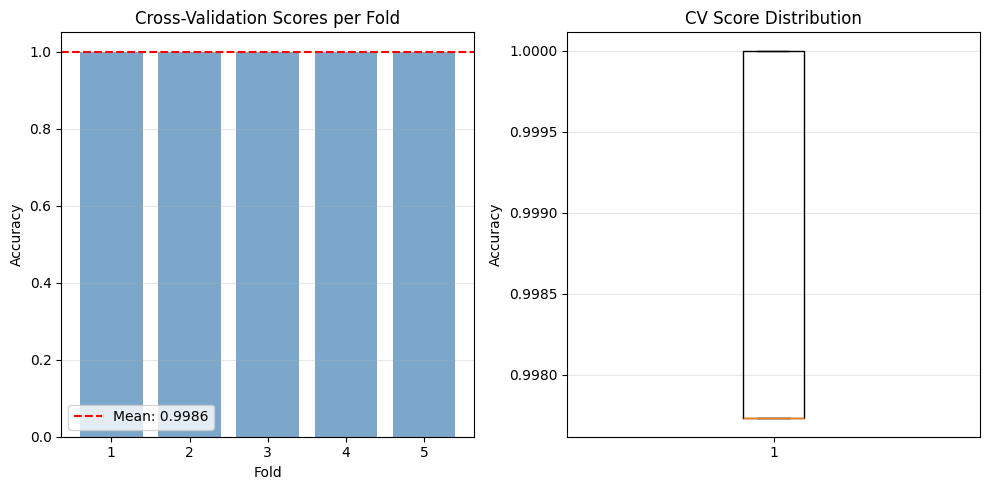


✅ Cross-validation provides more reliable performance estimate than single train-test split!


In [61]:
# 9️ CROSS-VALIDATION - Robust Performance Estimation
print("="*80)
print("🔄 CROSS-VALIDATION - 5-Fold Stratified")
print("="*80)

# Use best model configuration
best_config = configs[0]  # You can change based on previous results

# Create fresh pipeline
cv_pipeline = create_ml_pipeline(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    use_pca=best_config.get('use_pca', False),
    use_smote=best_config.get('use_smote', True)
)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cv_pipeline, X_selected, y, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"\n📊 Cross-Validation Results (5-Fold):")
print("="*60)
print(f"   Fold Scores: {cv_scores}")
print(f"   Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"   Min Accuracy:  {cv_scores.min():.4f}")
print(f"   Max Accuracy:  {cv_scores.max():.4f}")

# Visualize CV scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 6), cv_scores, color='steelblue', alpha=0.7)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores per Fold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores, vert=True)
plt.ylabel('Accuracy')
plt.title('CV Score Distribution')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Cross-validation provides more reliable performance estimate than single train-test split!")
print("="*80)


🎯 FEATURE IMPORTANCE ANALYSIS

🏆 Top 15 Most Important Features:
     Feature  Importance
     CP_mean    0.131082
     CE_mean    0.125825
profile_skew    0.100802
      CP_max    0.095481
      CE_max    0.090676
    TS4_mean    0.088807
      CP_min    0.081267
      CE_min    0.075785
     TS4_min    0.059934
     PS6_max    0.043449
     TS4_max    0.024091
    PS5_mean    0.023375
     PS5_max    0.019657
     PS6_min    0.014504
     PS1_min    0.009850


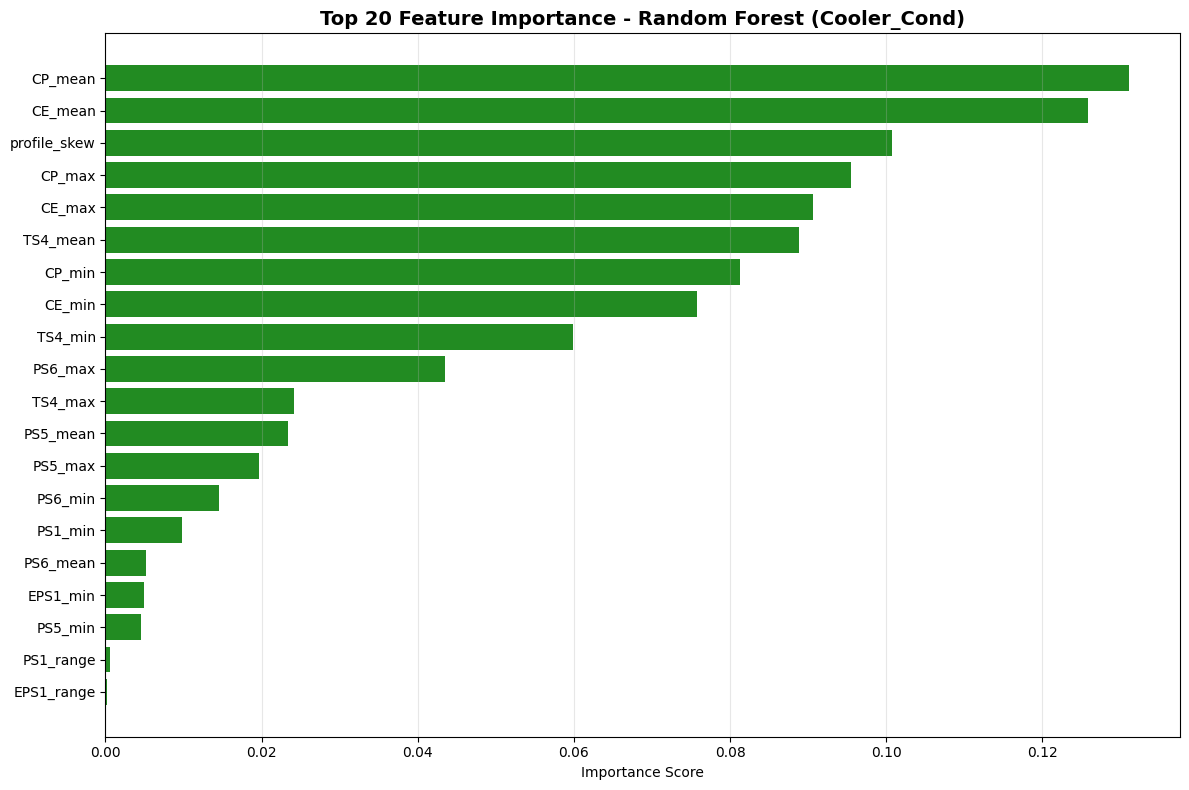

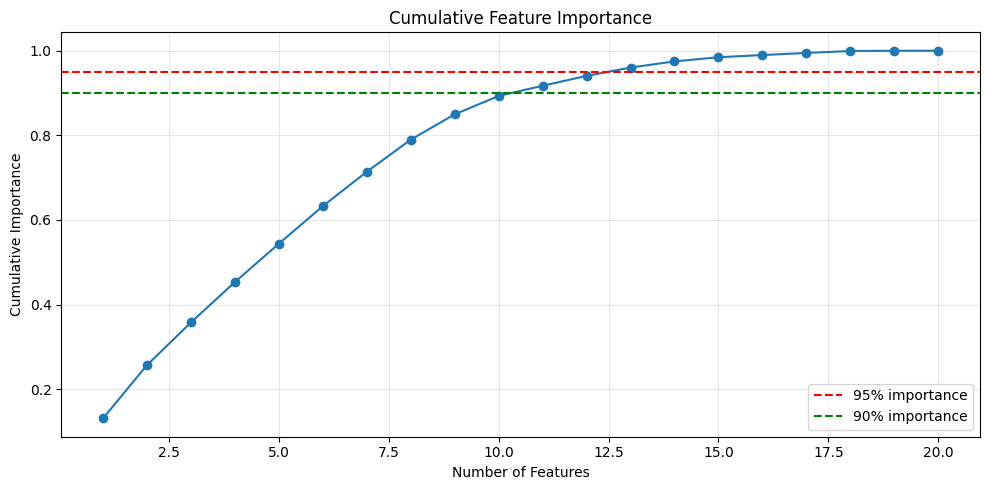


💡 Insight: Top 13 features capture 95% of importance!


In [62]:
# 10 FEATURE IMPORTANCE ANALYSIS
print("="*80)
print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Train a Random Forest to get feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Simple pipeline for feature importance (no SMOTE, to get proper importance)
simple_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', rf_model)
])

simple_pipeline.fit(X_train, y_train)

# Extract feature importance
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': top_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(f"\n🏆 Top 15 Most Important Features:")
print("="*60)
print(feature_importance_df.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))

# Top 20 features
top_20_importance = feature_importance_df.head(20)
plt.barh(range(len(top_20_importance)), top_20_importance['Importance'], color='forestgreen')
plt.yticks(range(len(top_20_importance)), top_20_importance['Feature'])
plt.xlabel('Importance Score')
plt.title(f'Top 20 Feature Importance - Random Forest ({TARGET})', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Cumulative importance
cumsum_importance = np.cumsum(feature_importance_df['Importance'].values)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumsum_importance)+1), cumsum_importance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% importance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

n_features_95 = np.argmax(cumsum_importance >= 0.95) + 1
print(f"\n💡 Insight: Top {n_features_95} features capture 95% of importance!")
print("="*80)


In [63]:
# 1️⃣1️⃣ MODEL PERSISTENCE - Save & Load (MLOps Best Practice)
print("="*80)
print("💾 MODEL PERSISTENCE - Save Best Model")
print("="*80)

# Create models directory
import os
os.makedirs('models', exist_ok=True)

# Model metadata
model_metadata = {
    'target': TARGET,
    'model_name': best_model['Model'],
    'configuration': best_model['Configuration'],
    'accuracy': best_model['Accuracy'],
    'f1_score': best_model['F1-Score'],
    'features_used': top_features,
    'n_features': len(top_features),
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'cv_mean_accuracy': cv_scores.mean(),
    'cv_std_accuracy': cv_scores.std()
}

# Save model pipeline
model_filename = f"models/best_model_{TARGET.lower()}.pkl"
joblib.dump(best_pipeline, model_filename)
print(f"\n✅ Model saved: {model_filename}")

# Save metadata
metadata_filename = f"models/metadata_{TARGET.lower()}.pkl"
joblib.dump(model_metadata, metadata_filename)
print(f"✅ Metadata saved: {metadata_filename}")

# Save feature names
features_filename = f"models/features_{TARGET.lower()}.pkl"
joblib.dump(top_features, features_filename)
print(f"✅ Features saved: {features_filename}")

# Demonstrate loading
print("\n" + "="*60)
print("🔄 Testing Model Loading...")
print("="*60)

loaded_pipeline = joblib.load(model_filename)
loaded_metadata = joblib.load(metadata_filename)
loaded_features = joblib.load(features_filename)

print(f"\n✅ Model loaded successfully!")
print(f"   Target: {loaded_metadata['target']}")
print(f"   Model: {loaded_metadata['model_name']}")
print(f"   Accuracy: {loaded_metadata['accuracy']:.4f}")
print(f"   Features: {loaded_metadata['n_features']}")
print(f"   Trained: {loaded_metadata['training_date']}")

# Test prediction
test_sample = X_test.iloc[:5]
predictions = loaded_pipeline.predict(test_sample)
print(f"\n🧪 Test predictions on 5 samples:")
print(f"   Predicted: {predictions}")
print(f"   Actual:    {y_test.iloc[:5].values}")

print("\n" + "="*80)
print("✅ Model persistence workflow completed!")
print("="*80)


💾 MODEL PERSISTENCE - Save Best Model

✅ Model saved: models/best_model_cooler_cond.pkl
✅ Metadata saved: models/metadata_cooler_cond.pkl
✅ Features saved: models/features_cooler_cond.pkl

🔄 Testing Model Loading...

✅ Model loaded successfully!
   Target: Cooler_Cond
   Model: Random Forest
   Accuracy: 1.0000
   Features: 20
   Trained: 2025-10-14 12:09:27

🧪 Test predictions on 5 samples:
   Predicted: [100   3  20   3 100]
   Actual:    [100   3  20   3 100]

✅ Model persistence workflow completed!


## 🎯 MULTI-TARGET TRAINING - All 4 Components

Now let's train models for ALL 4 target conditions:
1. Cooler Condition
2. Valve Condition  
3. Pump Leakage
4. Accumulator Pressure

In [64]:
# 1️⃣2️⃣ MULTI-TARGET TRAINING - Train Best Model for All Targets
print("="*80)
print("🎯 MULTI-TARGET TRAINING - Training for All 4 Components")
print("="*80)

# Store results for all targets
all_targets_results = {}

# Best model configuration (based on previous experiments)
BEST_MODEL = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

for target_name in targets:
    print(f"\n{'='*80}")
    print(f"🔄 Training for: {target_name}")
    print(f"{'='*80}")

    # Prepare data
    y_target = full_df[target_name].copy()
    top_features_target = top_features_dict[target_name]
    X_target = X_all[top_features_target]

    # Split data
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_target, y_target,
        test_size=0.2,
        random_state=42,
        stratify=y_target
    )

    # Create and train pipeline
    pipeline = create_ml_pipeline(BEST_MODEL, use_pca=False, use_smote=True)
    pipeline.fit(X_tr, y_tr)

    # Predictions
    y_pred = pipeline.predict(X_te)

    # Metrics
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='weighted')

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores_target = cross_val_score(pipeline, X_target, y_target, cv=skf, scoring='accuracy', n_jobs=-1)

    # Store results
    all_targets_results[target_name] = {
        'pipeline': pipeline,
        'features': top_features_target,
        'accuracy': acc,
        'f1_score': f1,
        'cv_mean': cv_scores_target.mean(),
        'cv_std': cv_scores_target.std(),
        'X_train': X_tr,
        'X_test': X_te,
        'y_train': y_tr,
        'y_test': y_te,
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_te, y_pred)
    }

    print(f"\n📊 Results:")
    print(f"   Test Accuracy:  {acc:.4f}")
    print(f"   Test F1-Score:  {f1:.4f}")
    print(f"   CV Accuracy:    {cv_scores_target.mean():.4f} (+/- {cv_scores_target.std():.4f})")
    print(f"   Features used:  {len(top_features_target)}")

    # Save model
    model_file = f"models/best_model_{target_name.lower()}.pkl"
    joblib.dump(pipeline, model_file)

    metadata = {
        'target': target_name,
        'model': 'RandomForestClassifier',
        'accuracy': acc,
        'f1_score': f1,
        'cv_mean': cv_scores_target.mean(),
        'cv_std': cv_scores_target.std(),
        'features': top_features_target,
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    joblib.dump(metadata, f"models/metadata_{target_name.lower()}.pkl")

    print(f"   ✅ Model saved: {model_file}")

print("\n" + "="*80)
print("✅ All models trained and saved successfully!")
print("="*80)


🎯 MULTI-TARGET TRAINING - Training for All 4 Components

🔄 Training for: Cooler_Cond

📊 Results:
   Test Accuracy:  1.0000
   Test F1-Score:  1.0000
   CV Accuracy:    0.9986 (+/- 0.0011)
   Features used:  20
   ✅ Model saved: models/best_model_cooler_cond.pkl

🔄 Training for: Valve_Cond

📊 Results:
   Test Accuracy:  0.9887
   Test F1-Score:  0.9887
   CV Accuracy:    0.9918 (+/- 0.0023)
   Features used:  20
   ✅ Model saved: models/best_model_valve_cond.pkl

🔄 Training for: Pump_Leak

📊 Results:
   Test Accuracy:  0.9955
   Test F1-Score:  0.9955
   CV Accuracy:    0.9941 (+/- 0.0040)
   Features used:  20
   ✅ Model saved: models/best_model_pump_leak.pkl

🔄 Training for: Accumulator_Press

📊 Results:
   Test Accuracy:  0.9864
   Test F1-Score:  0.9864
   CV Accuracy:    0.9937 (+/- 0.0026)
   Features used:  20
   ✅ Model saved: models/best_model_accumulator_press.pkl

✅ All models trained and saved successfully!


📊 COMPREHENSIVE RESULTS VISUALIZATION

📋 SUMMARY TABLE - All Targets
           Target  Test Accuracy  Test F1-Score  CV Mean Acc   CV Std  N Features
      Cooler_Cond       1.000000       1.000000     0.998639 0.001111          20
       Valve_Cond       0.988662       0.988713     0.991837 0.002312          20
        Pump_Leak       0.995465       0.995465     0.994104 0.003954          20
Accumulator_Press       0.986395       0.986436     0.993651 0.002644          20


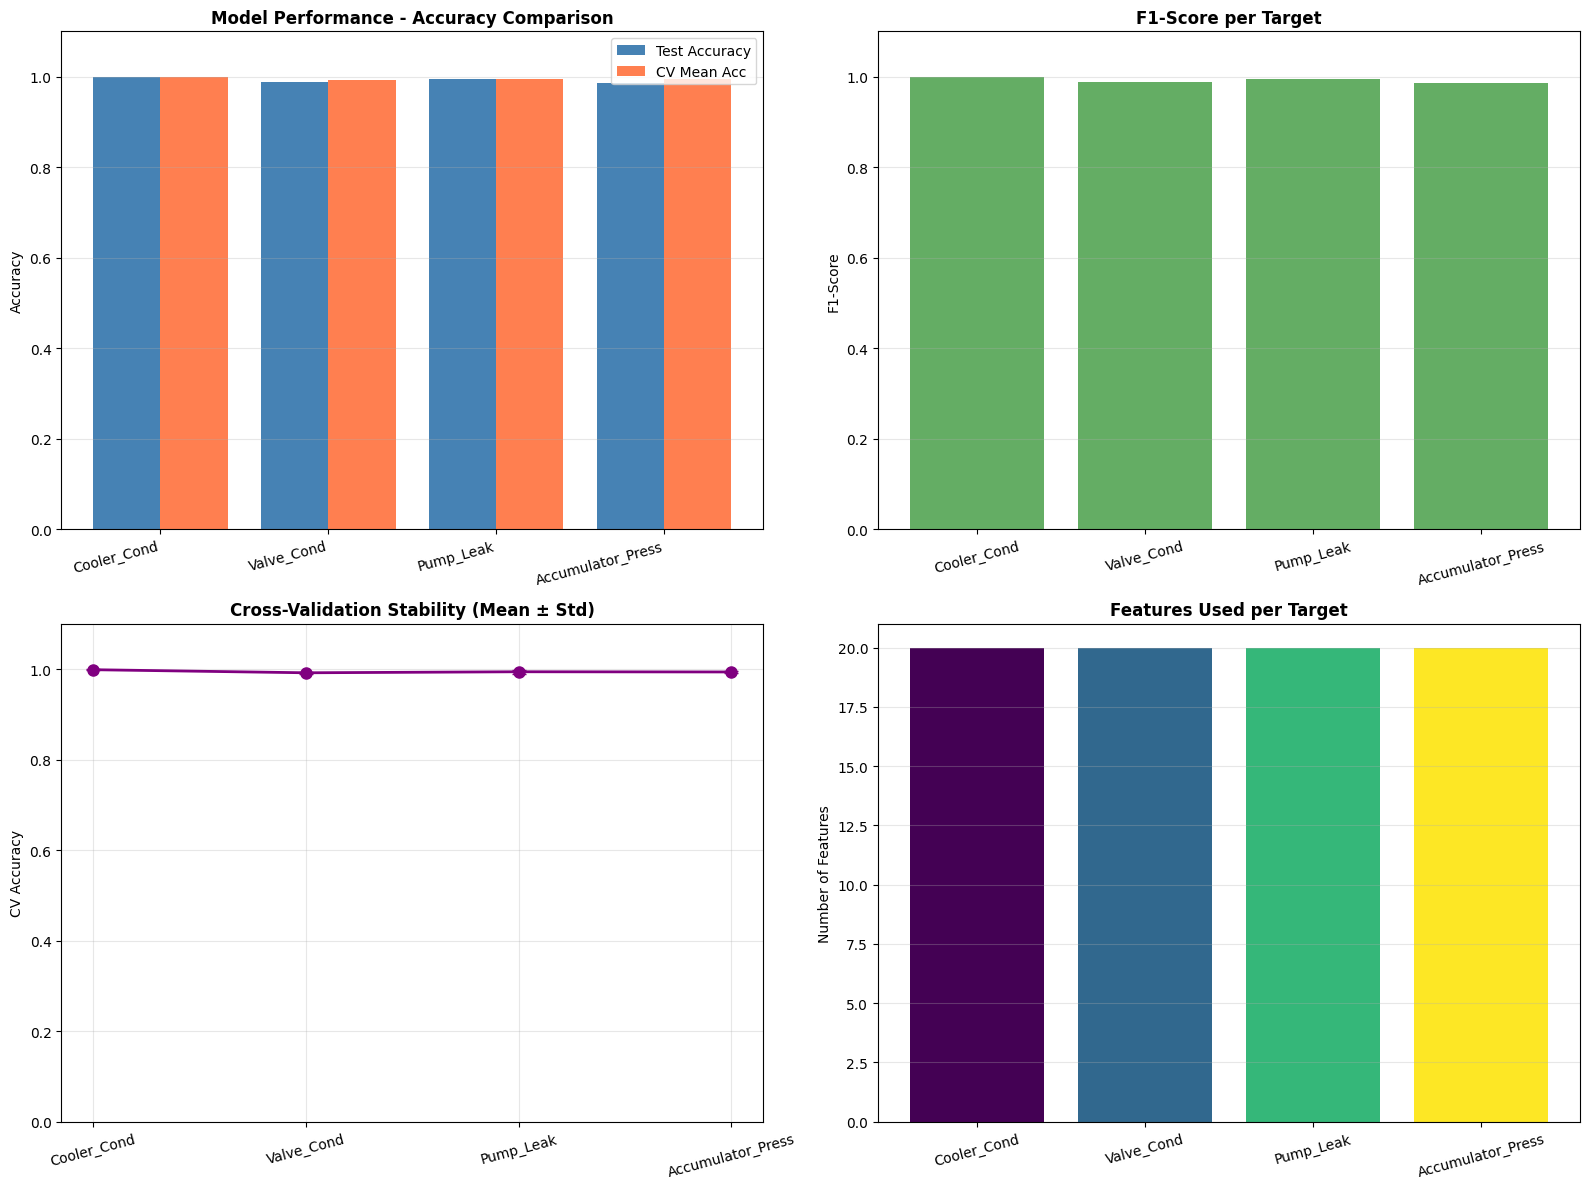


✅ Visualization completed!


In [65]:
# 1️⃣3️⃣ COMPREHENSIVE RESULTS VISUALIZATION - All Targets
print("="*80)
print("📊 COMPREHENSIVE RESULTS VISUALIZATION")
print("="*80)

# Create summary DataFrame
summary_data = []
for target_name, results in all_targets_results.items():
    summary_data.append({
        'Target': target_name,
        'Test Accuracy': results['accuracy'],
        'Test F1-Score': results['f1_score'],
        'CV Mean Acc': results['cv_mean'],
        'CV Std': results['cv_std'],
        'N Features': len(results['features'])
    })

summary_df = pd.DataFrame(summary_data)

print("\n📋 SUMMARY TABLE - All Targets")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Visualization 1: Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(summary_df))
ax1.bar(x_pos - 0.2, summary_df['Test Accuracy'], width=0.4, label='Test Accuracy', color='steelblue')
ax1.bar(x_pos + 0.2, summary_df['CV Mean Acc'], width=0.4, label='CV Mean Acc', color='coral')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(summary_df['Target'], rotation=15, ha='right')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Performance - Accuracy Comparison', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

# Plot 2: F1-Score comparison
ax2 = axes[0, 1]
ax2.bar(summary_df['Target'], summary_df['Test F1-Score'], color='forestgreen', alpha=0.7)
ax2.set_ylabel('F1-Score')
ax2.set_title('F1-Score per Target', fontweight='bold')
ax2.tick_params(axis='x', rotation=15)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.1])

# Plot 3: CV Stability (error bars)
ax3 = axes[1, 0]
ax3.errorbar(summary_df['Target'], summary_df['CV Mean Acc'],
             yerr=summary_df['CV Std'], fmt='o-', capsize=5,
             color='purple', markersize=8, linewidth=2)
ax3.set_ylabel('CV Accuracy')
ax3.set_title('Cross-Validation Stability (Mean ± Std)', fontweight='bold')
ax3.tick_params(axis='x', rotation=15)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 1.1])

# Plot 4: Number of features
ax4 = axes[1, 1]
colors_features = plt.cm.viridis(np.linspace(0, 1, len(summary_df)))
ax4.bar(summary_df['Target'], summary_df['N Features'], color=colors_features)
ax4.set_ylabel('Number of Features')
ax4.set_title('Features Used per Target', fontweight='bold')
ax4.tick_params(axis='x', rotation=15)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization completed!")
print("="*80)


🔢 CONFUSION MATRICES - All Targets


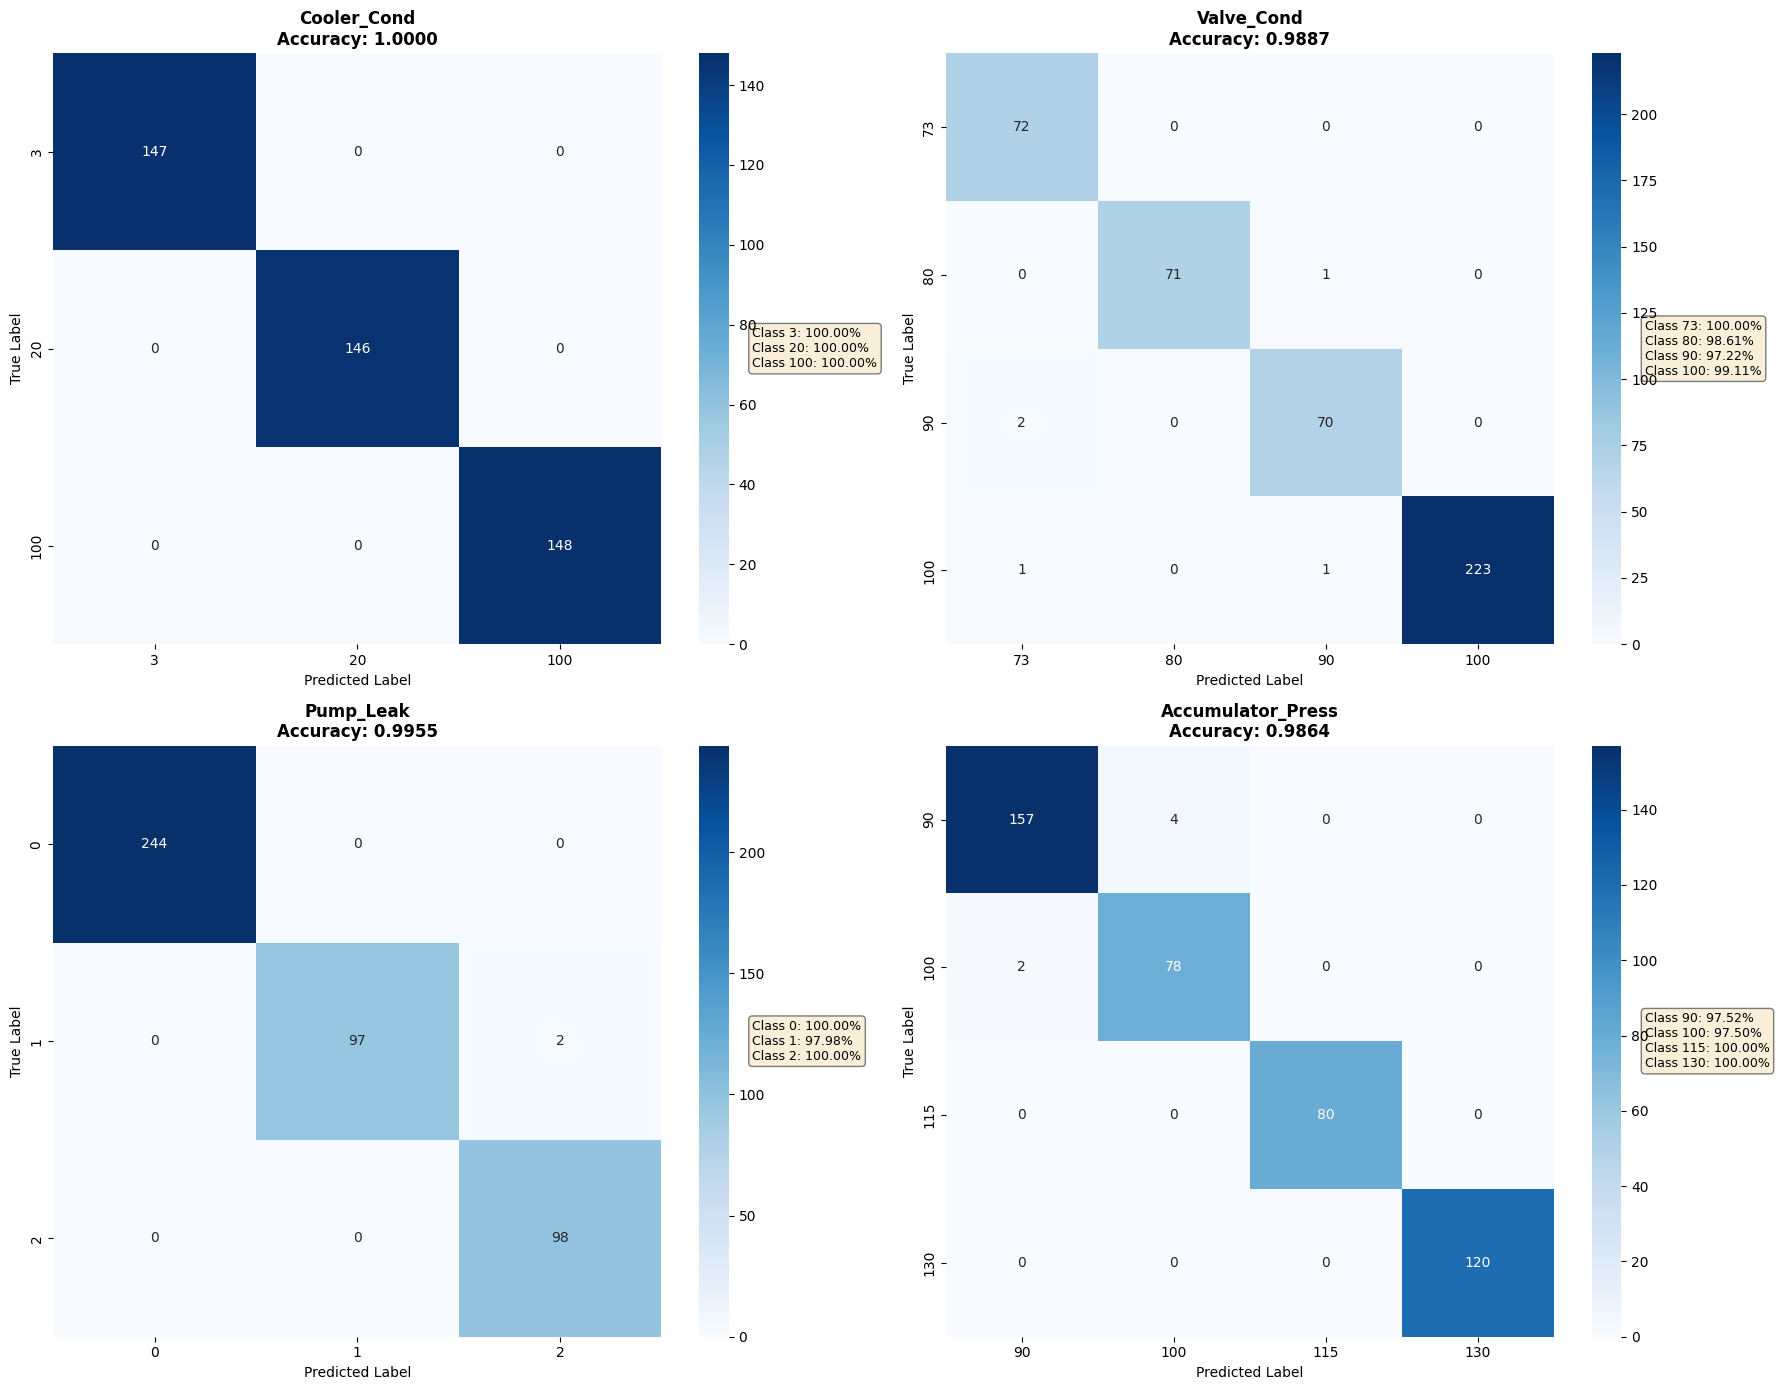


✅ Confusion matrices generated for all targets!


In [66]:
# 1️⃣4️⃣ CONFUSION MATRICES - All Targets
print("="*80)
print("🔢 CONFUSION MATRICES - All Targets")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, (target_name, results) in enumerate(all_targets_results.items()):
    cm = results['confusion_matrix']
    y_te = results['y_test']

    # Plot confusion matrix
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=sorted(y_te.unique()),
                yticklabels=sorted(y_te.unique()))

    ax.set_title(f'{target_name}\nAccuracy: {results["accuracy"]:.4f}',
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    # Add per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    textstr = '\n'.join([f'Class {sorted(y_te.unique())[i]}: {acc:.2%}'
                         for i, acc in enumerate(per_class_acc)])
    ax.text(1.15, 0.5, textstr, transform=ax.transAxes,
            fontsize=9, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✅ Confusion matrices generated for all targets!")
print("="*80)


In [67]:
# 1️⃣5️⃣ DETAILED CLASSIFICATION REPORTS - All Targets
print("="*80)
print("📋 DETAILED CLASSIFICATION REPORTS")
print("="*80)

for target_name, results in all_targets_results.items():
    print(f"\n{'='*80}")
    print(f"🎯 {target_name}")
    print(f"{'='*80}")

    y_te = results['y_test']
    y_pred = results['y_pred']

    # Classification report
    print(classification_report(y_te, y_pred, zero_division=0))

    print(f"\n📊 Additional Metrics:")
    print(f"   Total Test Samples: {len(y_te)}")
    print(f"   Correctly Classified: {(y_te == y_pred).sum()}")
    print(f"   Misclassified: {(y_te != y_pred).sum()}")
    print(f"   Error Rate: {(y_te != y_pred).sum() / len(y_te):.2%}")

print("\n" + "="*80)
print("✅ Classification reports completed!")
print("="*80)


📋 DETAILED CLASSIFICATION REPORTS

🎯 Cooler_Cond
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       147
          20       1.00      1.00      1.00       146
         100       1.00      1.00      1.00       148

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441


📊 Additional Metrics:
   Total Test Samples: 441
   Correctly Classified: 441
   Misclassified: 0
   Error Rate: 0.00%

🎯 Valve_Cond
              precision    recall  f1-score   support

          73       0.96      1.00      0.98        72
          80       1.00      0.99      0.99        72
          90       0.97      0.97      0.97        72
         100       1.00      0.99      1.00       225

    accuracy                           0.99       441
   macro avg       0.98      0.99      0.99       441
weighted avg       0.99      0.99      0.99       441




In [68]:
# 1️⃣6️⃣ PRODUCTION INFERENCE FUNCTION
print("="*80)
print("🚀 PRODUCTION-READY INFERENCE SYSTEM")
print("="*80)

class HydraulicConditionMonitor:
    """
    Production-ready hydraulic condition monitoring system

    Loads all trained models and provides unified prediction interface
    """

    def __init__(self, models_dir='models'):
        """Initialize by loading all trained models"""
        self.models_dir = models_dir
        self.targets = ['Cooler_Cond', 'Valve_Cond', 'Pump_Leak', 'Accumulator_Press']
        self.pipelines = {}
        self.metadata = {}
        self.features = {}

        # Load all models
        for target in self.targets:
            model_file = f"{models_dir}/best_model_{target.lower()}.pkl"
            metadata_file = f"{models_dir}/metadata_{target.lower()}.pkl"

            if os.path.exists(model_file):
                self.pipelines[target] = joblib.load(model_file)
                self.metadata[target] = joblib.load(metadata_file)
                self.features[target] = self.metadata[target]['features']
            else:
                print(f"⚠️  Model not found: {model_file}")

    def predict_single(self, sensor_data, target):
        """
        Predict condition for a single target

        Args:
            sensor_data: DataFrame with sensor features
            target: Target variable name

        Returns:
            prediction, probability (if available)
        """
        if target not in self.pipelines:
            raise ValueError(f"Model for {target} not loaded")

        # Select required features
        X = sensor_data[self.features[target]]

        # Predict
        prediction = self.pipelines[target].predict(X)

        # Get probabilities if available
        try:
            probabilities = self.pipelines[target].predict_proba(X)
        except:
            probabilities = None

        return prediction, probabilities

    def predict_all(self, sensor_data):
        """
        Predict all conditions for given sensor data

        Args:
            sensor_data: DataFrame with sensor features

        Returns:
            Dictionary with predictions for all targets
        """
        results = {}
        for target in self.targets:
            pred, prob = self.predict_single(sensor_data, target)
            results[target] = {
                'prediction': pred[0] if len(pred) == 1 else pred,
                'probabilities': prob
            }
        return results

    def get_model_info(self):
        """Get information about all loaded models"""
        info = []
        for target in self.targets:
            if target in self.metadata:
                meta = self.metadata[target]
                info.append({
                    'Target': target,
                    'Accuracy': f"{meta['accuracy']:.4f}",
                    'CV Mean': f"{meta['cv_mean']:.4f}",
                    'Features': len(meta['features']),
                    'Trained': meta['training_date']
                })
        return pd.DataFrame(info)

# Initialize the monitor
monitor = HydraulicConditionMonitor()

print("\n✅ Hydraulic Condition Monitor Initialized!")
print("\n📊 Loaded Models:")
print("="*80)
print(monitor.get_model_info().to_string(index=False))
print("="*80)


🚀 PRODUCTION-READY INFERENCE SYSTEM

✅ Hydraulic Condition Monitor Initialized!

📊 Loaded Models:
           Target Accuracy CV Mean  Features             Trained
      Cooler_Cond   1.0000  0.9986        20 2025-10-14 12:10:07
       Valve_Cond   0.9887  0.9918        20 2025-10-14 12:10:12
        Pump_Leak   0.9955  0.9941        20 2025-10-14 12:10:23
Accumulator_Press   0.9864  0.9937        20 2025-10-14 12:10:28


In [69]:
# 1️⃣7️⃣ INFERENCE DEMONSTRATION - Real-world Usage
print("="*80)
print("🧪 INFERENCE DEMONSTRATION")
print("="*80)

# Take a few test samples
test_samples = features_df.iloc[100:105]  # 5 random samples

print("\n🔍 Predicting conditions for 5 new sensor readings...")
print("="*80)

# Predict all conditions
predictions_all = monitor.predict_all(test_samples)

# Display results
for i, idx in enumerate(test_samples.index):
    print(f"\n{'='*60}")
    print(f"📊 Sample #{i+1} (Cycle {idx})")
    print(f"{'='*60}")

    for target in monitor.targets:
        pred = predictions_all[target]['prediction']
        prob = predictions_all[target]['probabilities']

        # Get actual value
        actual = full_df.loc[idx, target]

        # Status indicator
        status = "✅" if (isinstance(pred, np.ndarray) and pred[i] == actual) or (pred == actual) else "❌"

        if isinstance(pred, np.ndarray):
            pred_val = pred[i]
        else:
            pred_val = pred

        print(f"   {target:20s} | Predicted: {pred_val:6} | Actual: {actual:6} {status}")

print("\n" + "="*80)

# Example: Single target prediction
print("\n💡 Example: Predict only Cooler Condition")
print("="*80)

sample = test_samples.iloc[0:1]
pred, prob = monitor.predict_single(sample, 'Cooler_Cond')

print(f"   Prediction: {pred[0]}")
if prob is not None:
    print(f"   Probabilities: {prob[0]}")
    print(f"   Confidence: {prob[0].max():.2%}")

print("="*80)


🧪 INFERENCE DEMONSTRATION

🔍 Predicting conditions for 5 new sensor readings...

📊 Sample #1 (Cycle 100)
   Cooler_Cond          | Predicted:      3 | Actual:      3 ✅
   Valve_Cond           | Predicted:    100 | Actual:    100 ✅
   Pump_Leak            | Predicted:      0 | Actual:      0 ✅
   Accumulator_Press    | Predicted:    130 | Actual:    130 ✅

📊 Sample #2 (Cycle 101)
   Cooler_Cond          | Predicted:      3 | Actual:      3 ✅
   Valve_Cond           | Predicted:    100 | Actual:    100 ✅
   Pump_Leak            | Predicted:      0 | Actual:      0 ✅
   Accumulator_Press    | Predicted:    130 | Actual:    130 ✅

📊 Sample #3 (Cycle 102)
   Cooler_Cond          | Predicted:      3 | Actual:      3 ✅
   Valve_Cond           | Predicted:    100 | Actual:    100 ✅
   Pump_Leak            | Predicted:      0 | Actual:      0 ✅
   Accumulator_Press    | Predicted:    130 | Actual:    130 ✅

📊 Sample #4 (Cycle 103)
   Cooler_Cond          | Predicted:      3 | Actual:      3 ✅
 

In [ ]:
# Assuming X_all contains the original features before scaling for PCA
# And scaler contains the fitted StandardScaler object
# And X_scaled is the output of scaler.fit_transform(X_all)

# Get the original feature names
feature_names = X_all.columns

# Convert the scaled NumPy array back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# Define the filename for the downloaded file
download_filename = 'scaled_features_for_pca.csv'

# Save the DataFrame to a CSV file
X_scaled_df.to_csv(download_filename, index=False)

print(f"'{download_filename}' has been created and is ready for download.")